<h1 style="font-size: 64px">EDA for netflix dataset</h1>

<h2 style="font-size: 48px">Importing modules</h2>

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections as coll
from sklearn.cluster import KMeans
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import missingno as msno
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
#%matplotlib notebook

<h2 style="font-size: 48px">Basic look at the data</h2>

In [3]:
df = pd.read_csv("netflix_titles.csv")
df["year_added"] = pd.to_datetime(df["date_added"]).apply(lambda x: x.year).astype("Int64")
df["month_added"] = pd.to_datetime(df["date_added"]).apply(lambda x: x.month_name())
df["day_added"] = pd.to_datetime(df["date_added"]).apply(lambda x: x.day).astype("Int64")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,September,25
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,September,24
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,September,24
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,September,24
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,September,24


In [8]:
df["title"][1813]

'My Next Guest Needs No Introduction With David Letterman'

In [7]:
df["title"].str.len().sort_values(ascending=False)[:50]

/tmp/ipykernel_16935/74777083.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df["title"].str.len().sort_values(ascending=False)[:50]


5164    104
2813     93
3240     88
8462     88
4851     83
3479     79
7774     78
2773     77
1745     76
3364     75
6897     73
5196     71
2753     70
759      70
3802     69
8210     65
842      65
8350     64
5517     64
5788     64
760      62
7778     62
5808     62
400      62
6195     61
5660     61
5880     61
2128     61
3517     60
7324     60
8491     60
5659     60
1073     60
4590     59
3394     59
3759     59
5920     59
7090     58
6384     58
7788     58
62       58
51       57
7776     57
3395     57
2458     56
5397     56
4554     56
1553     56
7799     56
1813     56
Name: title, dtype: int64

In [12]:
#Lets add some style
sns.set_style("dark")

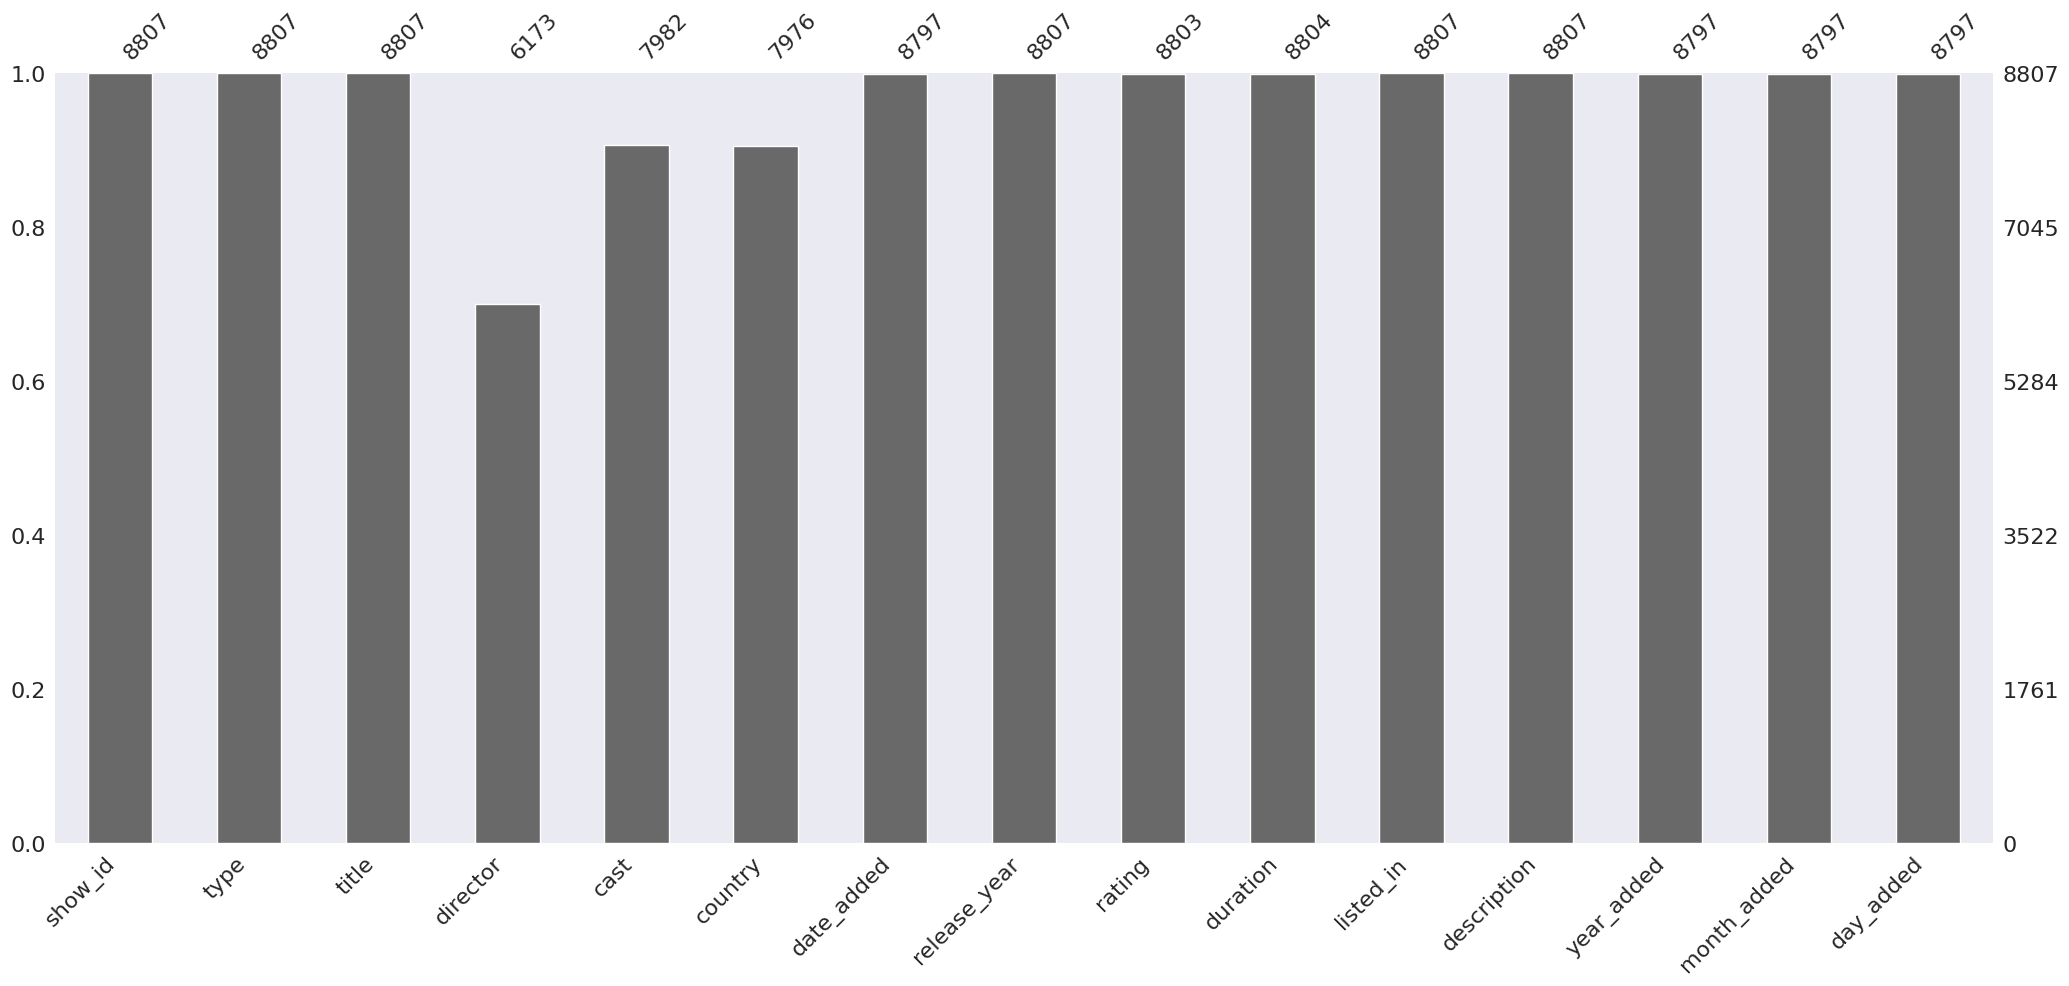

In [13]:
# Visualize missing values as a matrix
msno.bar(df);

# Basic look at the data

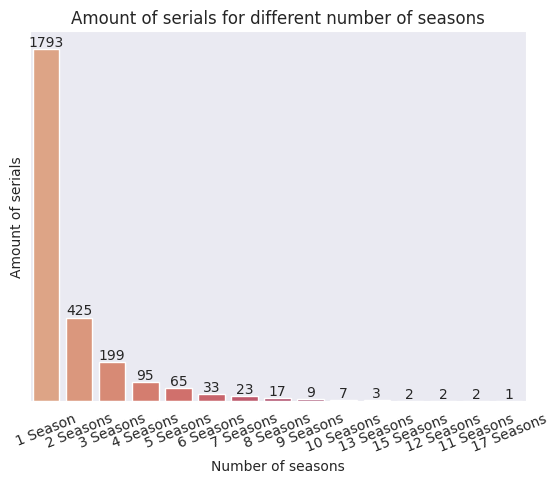

In [14]:
fig = plt.figure(label="No imagination")
amount_of_seasons = df["duration"].mask(df["type"] == "Movie").value_counts()
ax = sns.barplot(x=amount_of_seasons.index, y=amount_of_seasons, palette="flare")
ax.bar_label(ax.containers[0])
plt.xlabel('Number of seasons')
plt.ylabel('Amount of serials')
ax.set_yticks([])
plt.xticks(rotation = 22)
ax.set_title('Amount of serials for different number of seasons', loc="center");
#plt.bar();

<h3>Preproccess data about duration of film</h3>

In [15]:
#Some scary things
duration_of_the_film = df["duration"].mask(df["type"] == "TV Show").dropna().str.strip(" min").astype("int32", errors='raise').value_counts()
duration_of_the_film_copy = pd.Series(dtype="int32")
duration_of_the_film_copy["3H+"] = duration_of_the_film.where(duration_of_the_film.index >= 180).sum()
duration_of_the_film_copy["2.5H+"] = duration_of_the_film.where((duration_of_the_film.index >= 150) & (duration_of_the_film.index < 180)).sum()
duration_of_the_film_copy["2H+"] = duration_of_the_film.where((duration_of_the_film.index >= 120) & (duration_of_the_film.index < 150)).sum()
duration_of_the_film_copy["90m+"] = duration_of_the_film.where((duration_of_the_film.index >= 90) & (duration_of_the_film.index < 120)).sum()
duration_of_the_film_copy["1H+"] = duration_of_the_film.where((duration_of_the_film.index >= 60) & duration_of_the_film.index < 90).sum()
duration_of_the_film_copy["<45min"] = duration_of_the_film.where((duration_of_the_film.index <= 45) & (duration_of_the_film.index > 15)).sum()
duration_of_the_film_copy["<15min"] = duration_of_the_film.where(duration_of_the_film.index<=15).sum()

<h3>Plot data about duration of film</h3>

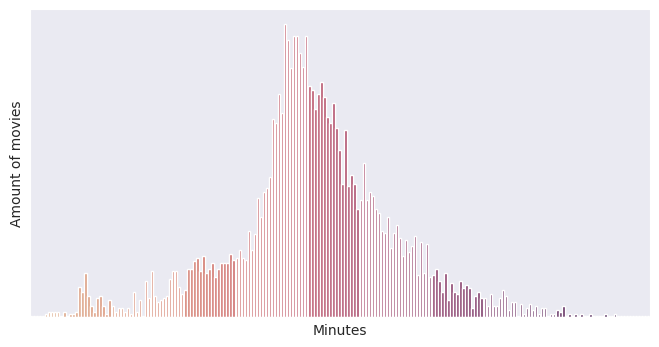

In [16]:
#Looks like a distribution to me
fig = plt.figure(figsize=(8,4), label="No imagination")
ax = sns.barplot(x=duration_of_the_film.index, y=duration_of_the_film, palette="flare")
#ax.bar_label(ax.containers[0])
plt.xlabel('Minutes') 
plt.ylabel('Amount of movies')
ax.set_yticks([])
ax.set_xticks([]);
#ax.set_xticks([])

### Now lets look at simpler version of that graph to get the general idea

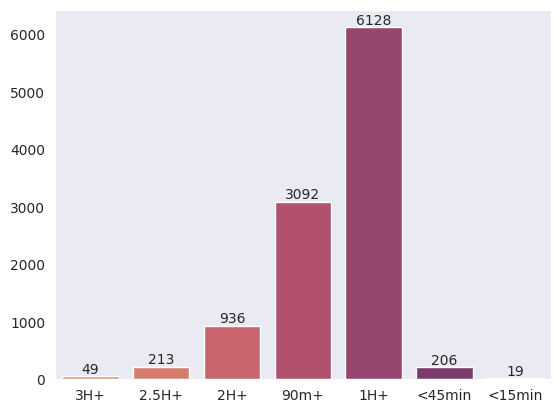

In [17]:
ax = sns.barplot(x=duration_of_the_film_copy.index, y=duration_of_the_film_copy, palette="flare");
ax.bar_label(ax.containers[0]);

# Amount of movies and tv shows that were filmed at some point of time

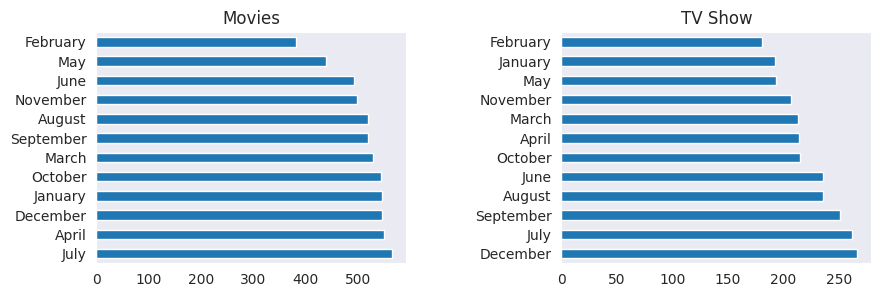

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)

month_added = df["month_added"].where(df["type"] == "Movie").dropna().value_counts()
month_added.plot(ax=axs[0],kind="barh", title="Movies");

month_added = df["month_added"].where(df["type"] == "TV Show").dropna().value_counts()
month_added.plot(ax=axs[1], kind="barh", title="TV Show");

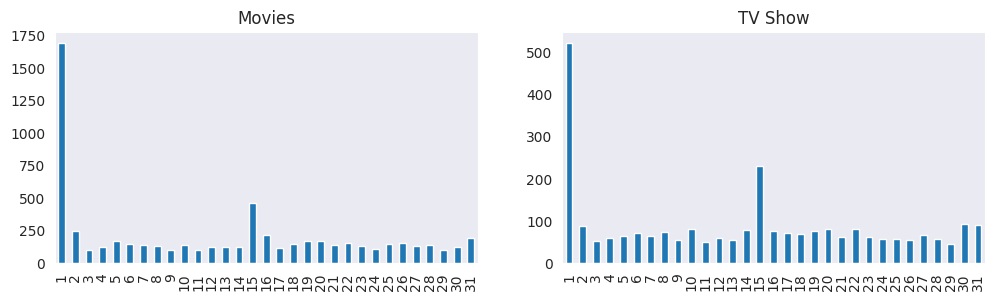

In [19]:
fig, axs = plt.subplots(1,2, figsize=(12,3))

day_added = df["day_added"].where(df["type"] == "Movie").dropna().value_counts()
day_added.sort_index(inplace=True)
day_added.plot(ax=axs[0],kind="bar", title="Movies");

day_added = df["day_added"].where(df["type"] == "TV Show").dropna().value_counts()
day_added.sort_index(inplace=True)
day_added.plot(ax=axs[1], kind="bar", title="TV Show");

In [20]:
?plt.bar

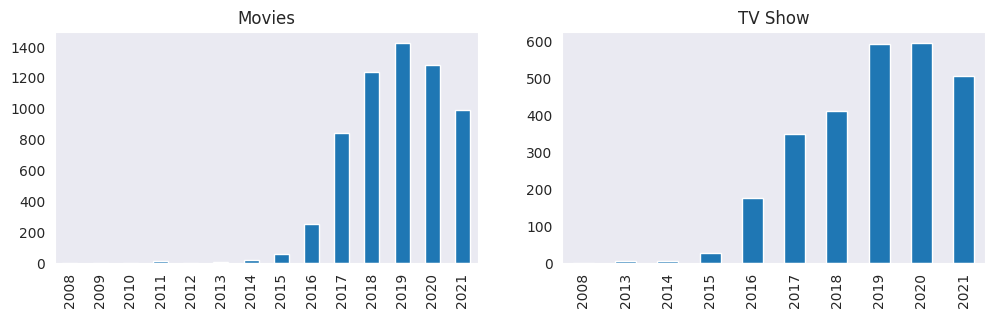

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12,3))

year_added = df["year_added"].where(df["type"] == "Movie").dropna().value_counts()
year_added.sort_index(inplace=True)
year_added.plot(ax=axs[0],kind="bar", title="Movies");

year_added = df["year_added"].where(df["type"] == "TV Show").dropna().value_counts()
year_added.sort_index(inplace=True)
year_added.plot(ax=axs[1], kind="bar", title="TV Show");

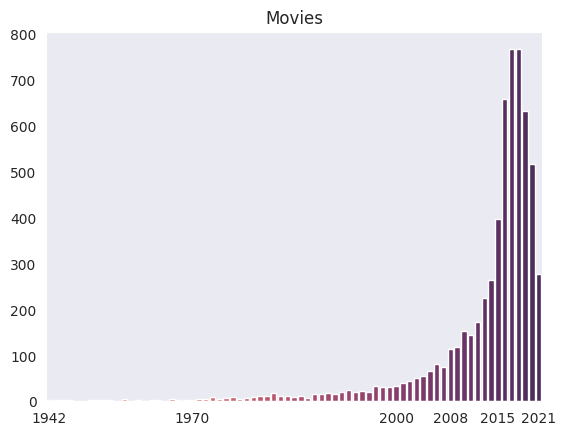

In [22]:
release_year = df["release_year"].where(df["type"] == "Movie").dropna().value_counts()
release_year.sort_index(ascending=False, inplace=True)
release_year.index = release_year.index.astype("int64")

ax = sns.barplot(x=release_year.index, y=release_year.values, palette="flare")
#ax.set_xticks([1925, 1970, 2000, 2021]);
for index, label in enumerate(ax.get_xticklabels()):
    if label.get_text() not in ["1942", "1970", "2000", "2008", "2015", "2021"]:
        label.set_visible(False)
ax.set(title='Movies');
#plt.xticks([1925,1970,2000,2021], ["1925", "1970", "2000", "2021"])

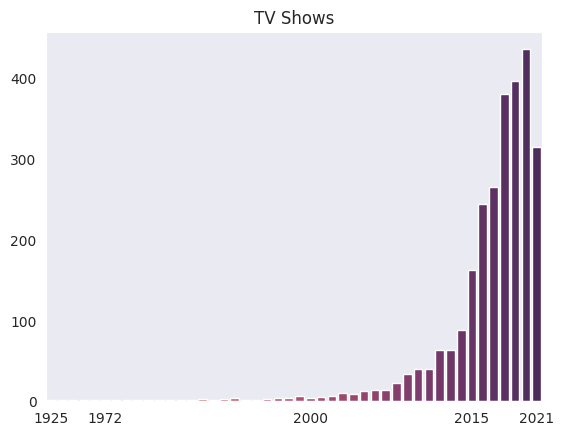

In [15]:
release_year_tv = df["release_year"].where(df["type"] == "TV Show").dropna().value_counts()
release_year_tv.sort_index(ascending=False, inplace=True)
release_year_tv.index = release_year_tv.index.astype("int64")

ax = sns.barplot(x=release_year_tv.index, y=release_year_tv.values, palette="flare")
#ax.set_xticks([1925, 1970, 2000, 2021]);
for index, label in enumerate(ax.get_xticklabels()):
    if label.get_text() not in ["1925", "1972", "2000", "2015", "2021"]:
        label.set_visible(False)

ax.set(title='TV Shows');
#plt.xticks([1925,1970,2000,2021], ["1925", "1970", "2000", "2021"])

# More in-depth look at the data

## TV Shows VS Movies

## Amount of Movies and TV Shows sorted by age rating

In [ ]:
lol = 

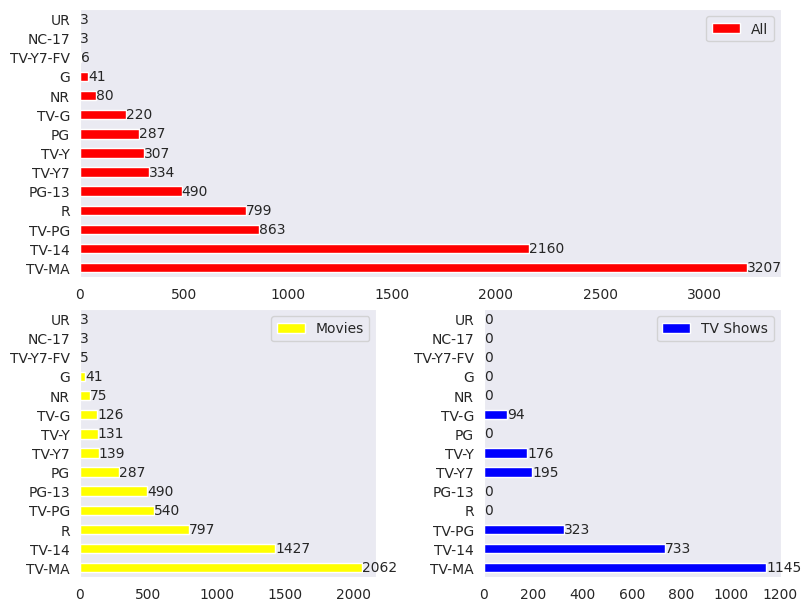

In [16]:
fig = plt.figure(figsize=(8,6), constrained_layout=True)
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

shiet = pd.Series(index=df["rating"].value_counts()[:-3].index, dtype="int64").fillna(0)
shiet += df["rating"].where(df["type"] == "TV Show").value_counts()[:-3]
df["rating"].value_counts()[:-3].plot(ax=ax1, kind="barh", color="red", legend=True, label="All");
df["rating"].where(df["type"] == "Movie").value_counts()[:-3].plot(ax=ax2, kind="barh", color="yellow", legend=True, label="Movies");
shiet.fillna(0).plot(ax=ax3, kind="barh", color="blue", legend=True, label="TV Shows");
ax1.bar_label(ax1.containers[0]);
ax2.bar_label(ax2.containers[0]);
ax3.bar_label(ax3.containers[0]);

In [128]:
lol1 = len(df["rating"].where(df["rating"] == "TV-Y").dropna()) + len(df["rating"].where(df["rating"] == "TV-G").dropna()) + len(df["rating"].where(df["rating"] == "NR").dropna()) + len(df["rating"].where(df["rating"] == "G").dropna())
lol2 = len(df["rating"].where(df["rating"] == "TV-PG").dropna()) + len(df["rating"].where(df["rating"] == "TV-Y7").dropna()) + len(df["rating"].where(df["rating"] == "PG").dropna()) + len(df["rating"].where(df["rating"] == "TV-Y7-FV").dropna())
lol3 = len(df["rating"].where(df["rating"] == "TV-14").dropna()) + len(df["rating"].where(df["rating"] == "PG-13").dropna())
lol4 = len(df["rating"].where(df["rating"] == "TV-MA").dropna()) + len(df["rating"].where(df["rating"] == "NC-17").dropna()) + len(df["rating"].where(df["rating"] == "UR").dropna())
lol5 = len(df["rating"].where(df["rating"] == "R").dropna())

In [486]:
df_genre_year

,Cult Movies,Action & Adventure,Anime Features,Comedies,Classic Movies,Sports Movies,Sci-Fi & Fantasy,Documentaries,Children & Family Movies,Thrillers,Dramas,Music & Musicals,Stand-Up Comedy,Movies,LGBTQ Movies,Romantic Movies,Horror Movies,Independent Movies,International Movies,Faith & Spirituality
2021,0.0,37.0,6.0,70.0,0.0,15.0,0.0,53.0,40.0,33.0,92.0,19.0,12.0,209.0,8.0,25.0,20.0,16.0,141.0,2.0
2020,0.0,46.0,3.0,133.0,0.0,17.0,1.0,77.0,83.0,45.0,195.0,37.0,41.0,389.0,17.0,61.0,29.0,46.0,239.0,5.0
2019,0.0,44.0,6.0,159.0,0.0,25.0,20.0,104.0,82.0,71.0,243.0,48.0,49.0,450.0,13.0,64.0,34.0,76.0,282.0,8.0
2018,1.0,81.0,8.0,178.0,1.0,27.0,42.0,120.0,69.0,83.0,304.0,43.0,59.0,540.0,13.0,64.0,51.0,131.0,340.0,15.0
2017,1.0,89.0,6.0,164.0,0.0,29.0,23.0,172.0,55.0,68.0,285.0,33.0,58.0,520.0,16.0,64.0,47.0,113.0,328.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1944,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1942,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [529]:
all_kids = pd.DataFrame(columns=df_genre_year.columns, index=["G", "TV-Y", "TV-G", "NR"])
for i in all_kids.columns:
    for j in all_kids.index:
        all_kids[i][j] = df["title"].where((df["rating"] == j) & (df["listed_in"].str.find(i) > -1)).dropna().value_counts().sum()
all_kids = all_kids.sum().astype("int64")
all_kids.drop(["Movies", "International Movies"], inplace=True)

In [526]:
kids = pd.DataFrame(columns=df_genre_year.columns, index=["TV-PG", "TV-Y7", "PG", "TV-Y7-FV"])
for i in kids.columns:
    for j in kids.index:
        kids[i][j] = df["title"].where((df["rating"] == j) & (df["listed_in"].str.find(i) > -1)).dropna().value_counts().sum()
kids = kids.sum().astype("int64")
kids.drop(["Movies", "International Movies"], inplace=True)

In [536]:
teens = pd.DataFrame(columns=df_genre_year.columns, index=["TV-14", "PG-13"])
for i in teens.columns:
    for j in teens.index:
        teens[i][j] = df["title"].where((df["rating"] == j) & (df["listed_in"].str.find(i) > -1)).dropna().value_counts().sum()
teens = teens.sum().astype("int64")
teens.drop(["Movies", "International Movies"], inplace=True)

In [546]:
adult = pd.DataFrame(columns=df_genre_year.columns, index=["TV-MA", "NC-17", "R", "UR"])
for i in adult.columns:
    for j in adult.index:
        adult[i][j] = df["title"].where((df["rating"] == j) & (df["listed_in"].str.find(i) > -1)).dropna().value_counts().sum()
adult = adult.sum().astype("int64")
adult.drop(["Movies", "International Movies"], inplace=True)

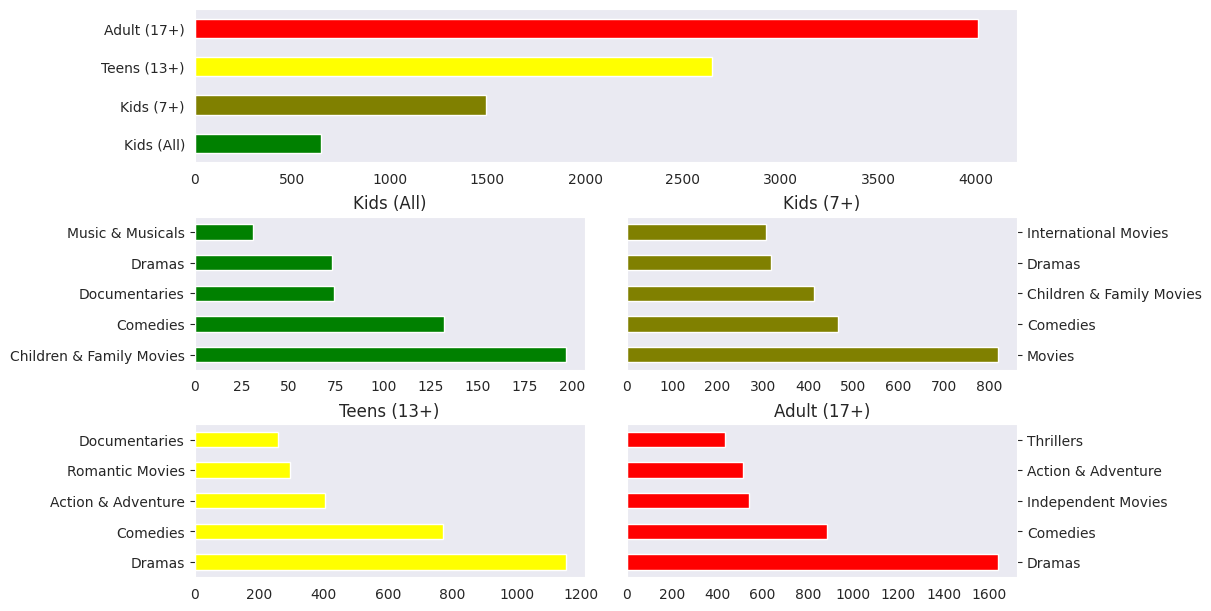

In [549]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
gs = mpl.gridspec.GridSpec(3,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
pd.DataFrame([[lol1,lol2,lol3,lol4+lol5], [lol1,lol2,lol3,lol4+lol5], [lol1,lol2,lol3,lol4+lol5], [lol1,lol2,lol3,lol4+lol5]], columns=["Kids (All)", "Kids (7+)", "Teens (13+)", "Adult (17+)"]).max().plot(ax=ax1, kind="barh", legend=False, color=["green", "olive", "yellow", "red"]);
all_kids.nlargest(n=5).plot(kind="barh",ax=ax2, title="Kids (All)", color="green");
ax2.yaxis.tick_left()
kids.nlargest(n=5).plot(kind="barh",ax=ax3, title="Kids (7+)", color="olive");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
teens.nlargest(n=5).plot(kind="barh",ax=ax4, title="Teens (13+)", color="yellow");
ax4.yaxis.tick_left()
adult.nlargest(n=5).plot(kind="barh",ax=ax5, title="Adult (17+)", color="red");
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()

### Prepare data to look into information about genres and for a deeper look about rating

In [17]:
colors=["red", "blue", "black", "purple", "pink", "olive", "maroon"]

df_listed_in_show = df["listed_in"].where(df["type"] == "TV Show").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()
df_listed_in_movie = df["listed_in"].where(df["type"] == "Movie").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()

df_cast_show = df["cast"].where(df["type"] == "TV Show").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()
df_cast_movie = df["cast"].where(df["type"] == "Movie").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()

df_directors_show = df["director"].where(df["type"] == "TV Show").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()
df_directors_movie = df["director"].where(df["type"] == "Movie").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()

df_country_show = df["country"].where(df["type"] == "TV Show").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()
df_country_movie = df["country"].where(df["type"] == "Movie").dropna().apply(lambda x: [I.strip() for I in x.split(", ")]).explode().value_counts()


df_listed_in_show.sort_values(ascending=True, inplace=True)
df_listed_in_movie.sort_values(ascending=True, inplace=True)

df_cast_show.sort_values(ascending=False, inplace=True)
df_cast_movie.sort_values(ascending=False, inplace=True)

df_directors_show.sort_values(ascending=False, inplace=True)
df_directors_movie.sort_values(ascending=False, inplace=True)

df_country_show.sort_values(ascending=False, inplace=True)
df_country_movie.sort_values(ascending=False, inplace=True)

#df_country_movie

In [18]:
listed_in = set()
for i in df["listed_in"]:
    listed_in.update(i.split(", "))
listed_in = list(listed_in)
    
cast = set()
for i in df["cast"].dropna():
    cast.update(i.split(", "))
cast = list(cast)
    
directors = set()
for i in df["director"].dropna():
    directors.update(i.split(", "))
directors = list(directors)
    
country = set()
for i in df["country"].dropna():
    country.update(i.split(", "))
country = list(country)

In [162]:
?pd.DataFrame.plot

In [168]:
def show_label(df_for_labels):
    return [i + "\n" + str(int(df_for_labels[i].sum())) + " : " + str(round(df_for_labels[i].sum()/df_for_labels.sum().sum()*100, 2)) + "%" for i in df_for_labels.columns]

def plot_area(axs, data, step, loc=2, rot=0, kind="area", n_cat=1, num_cat=1, title="Movies", legend_title="", y_label=None, x_label=None, colors=None, plt_fontsize=None, show_labels=True, x_ticks=None, ncol=2):
    n_cat-=1
    if show_labels:
        data.columns = show_label(data)
    axs = axs.ravel()
    data.T[:step].T.plot(ax = axs[n_cat], yticks=[], rot=rot, kind=kind, title=title, xlabel=x_label, ylabel=y_label, color=colors, fontsize=plt_fontsize);
    axs[n_cat].legend(loc=loc, ncol=ncol, prop={'size': 7}, title=f"{legend_title}Top 1-{step}");
    if x_ticks is not None:
        axs[n_cat].set_xticks(range(len(x_ticks)))
        axs[n_cat].set_xticklabels(x_ticks)
    
    n_cat +=num_cat
    data.T[step:step*2].T.plot(ax = axs[n_cat], yticks=[], rot=rot, kind=kind, xlabel=x_label, ylabel=y_label, color=colors, fontsize=plt_fontsize);
    axs[n_cat].legend(loc=loc, ncol=ncol, prop={'size': 7}, title=f"{legend_title}Top {step+1}-{step*2}");
    if x_ticks is not None:
        axs[n_cat].set_xticks(range(len(x_ticks)))
        axs[n_cat].set_xticklabels(x_ticks)

    n_cat +=num_cat
    data.T[step*2:step*3].T.plot(ax = axs[n_cat], rot=rot, kind=kind, xlabel=x_label, ylabel=y_label, color=colors, fontsize=plt_fontsize);
    axs[n_cat].legend(loc=loc, ncol=ncol, prop={'size': 7}, title=f"{legend_title}Top {step*2+1}-{step*3}");
    if x_ticks is not None:
        axs[n_cat].set_xticks(range(len(x_ticks)))
        axs[n_cat].set_xticklabels(x_ticks)
    
    n_cat +=num_cat
    data.T[step*3:step*4].T.plot(ax = axs[n_cat], rot=rot, kind=kind,xlabel=x_label, ylabel=y_label, color=colors, fontsize=plt_fontsize);
    axs[n_cat].legend(loc=loc, ncol=ncol, prop={'size': 7}, title=f"{legend_title}Top {step*3+1}-{step*4}");
    if x_ticks is not None:
        axs[n_cat].set_xticks(range(len(x_ticks)))
        axs[n_cat].set_xticklabels(x_ticks)

In [20]:
df_genre_year = pd.DataFrame(index=release_year.index, columns=list(listed_in)).fillna(0)

buffer_movie = df[["release_year", "listed_in", "type"]].where(df["type"] == "Movie").dropna().drop("type", axis="columns").set_index("release_year").sort_values(by="release_year", ascending=False)
buffer_shows = df[["release_year", "listed_in", "type"]].where(df["type"] == "TV Show").dropna().drop("type", axis="columns").set_index("release_year").sort_values(by="release_year", ascending=False)
df_genre_shows = df_genre_year.copy()

for i in df_genre_year.columns:
    df_genre_year[i] += buffer_movie.index.where((buffer_movie["listed_in"].str.findall(i))).value_counts().fillna(0)
    df_genre_shows[i] += buffer_shows.index.where((buffer_shows["listed_in"].str.findall(i))).value_counts().fillna(0)

df_genre_year = df_genre_year.sort_index(ascending=False)
df_genre_shows = df_genre_shows.sort_index(ascending=False)

for i in df_genre_year.columns:
    if df_genre_year[i].sum() == 0:
        df_genre_year.drop(i, axis="columns", inplace=True)
    if df_genre_shows[i].sum() == 0:
        df_genre_shows.drop(i, axis="columns", inplace=True)

df_genre_year = df_genre_year.fillna(0)

for i in df_genre_shows.columns:
    if "TV" not in i:
        df_genre_shows.drop(i, axis="columns", inplace=True)

df_genre_shows = df_genre_shows.fillna(0)

In [21]:
df_genre_month = pd.DataFrame(index=month_added.index, columns=list(listed_in)).fillna(0)
df_genre_month_shows = df_genre_month.copy()

buffer_movie = df[["month_added", "listed_in", "type"]].where(df["type"] == "Movie").dropna().drop("type", axis="columns").set_index("month_added").sort_values(by="month_added", ascending=False)
buffer_shows = df[["month_added", "listed_in", "type"]].where(df["type"] == "TV Show").dropna().drop("type", axis="columns").set_index("month_added").sort_values(by="month_added", ascending=False)

for i in df_genre_month.columns:
    df_genre_month[i] += buffer_movie.index.where((buffer_movie["listed_in"].str.findall(i))).value_counts().fillna(0)
    df_genre_month_shows[i] += buffer_shows.index.where((buffer_shows["listed_in"].str.findall(i))).value_counts().fillna(0)

df_genre_month = df_genre_month.sort_index(ascending=False)
df_genre_month_shows = df_genre_month_shows.sort_index(ascending=False)

for i in df_genre_month.columns:
    if df_genre_month[i].sum() == 0:
        df_genre_month.drop(i, axis="columns", inplace=True)
    if df_genre_month_shows[i].sum() == 0:
        df_genre_month_shows.drop(i, axis="columns", inplace=True)

df_genre_month = df_genre_month.fillna(0)

for i in df_genre_month_shows.columns:
    if "TV" not in i:
        df_genre_month_shows.drop(i, axis="columns", inplace=True)

df_genre_month_shows = df_genre_month_shows.fillna(0)

In [22]:
df_genre_month_shows = pd.DataFrame([df_genre_month_shows.T["January"], 
                                     df_genre_month_shows.T["February"], 
                                     df_genre_month_shows.T["March"], 
                                     df_genre_month_shows.T["April"], 
                                     df_genre_month_shows.T["May"], 
                                     df_genre_month_shows.T["June"], 
                                     df_genre_month_shows.T["July"], 
                                     df_genre_month_shows.T["August"], 
                                     df_genre_month_shows.T["September"], 
                                     df_genre_month_shows.T["October"], 
                                     df_genre_month_shows.T["November"], 
                                     df_genre_month_shows.T["December"]])

In [23]:
df_genre_month = pd.DataFrame([df_genre_month.T["January"], 
                               df_genre_month.T["February"], 
                               df_genre_month.T["March"], 
                               df_genre_month.T["April"], 
                               df_genre_month.T["May"], 
                               df_genre_month.T["June"], 
                               df_genre_month.T["July"], 
                               df_genre_month.T["August"], 
                               df_genre_month.T["September"], 
                               df_genre_month.T["October"], 
                               df_genre_month.T["November"], 
                               df_genre_month.T["December"]])

In [24]:
df_cast_movie = pd.DataFrame(index=release_year.index, columns=df_cast_movie.index[:20], dtype="int32").fillna(0)
df_cast_show = pd.DataFrame(index=release_year.index, columns=df_cast_show.index[:20], dtype="int32").fillna(0)

df_directors_movie = pd.DataFrame(index=release_year.index, columns=df_directors_movie.index[:20], dtype="int32").fillna(0)
df_directors_show = pd.DataFrame(index=release_year.index, columns=df_directors_show.index[:20], dtype="int32").fillna(0)

df_country_movie = pd.DataFrame(index=release_year.index, columns=df_country_movie.index[:20], dtype="int32").fillna(0)
df_country_show = pd.DataFrame(index=release_year.index, columns=df_country_show.index[:20], dtype="int32").fillna(0)

df_country_genre_movie = pd.DataFrame(index=df_genre_year.columns, columns=df_country_movie.columns[:20], dtype="int32").fillna(0)
df_country_genre_show = pd.DataFrame(index=df_genre_shows.columns, columns=df_country_show.columns[:20], dtype="int32").fillna(0)

for i in df_cast_movie.columns:
    df_cast_movie[i] += df["release_year"].where(df["cast"].str.find(i) > -1).dropna().value_counts()
    df_cast_movie = df_cast_movie.fillna(0)

for i in df_cast_show.columns:
    df_cast_show[i] += df["release_year"].where(df["cast"].str.find(i) > -1).dropna().value_counts()
    df_cast_show = df_cast_show.fillna(0)
    
for i in df_directors_movie.columns:
    df_directors_movie[i] += df["release_year"].where(df["director"].str.find(i) > -1).dropna().value_counts()
    df_directors_movie = df_directors_movie.fillna(0)

for i in df_directors_show.columns:
    df_directors_show[i] += df["release_year"].where(df["director"].str.find(i) > -1).dropna().value_counts()
    df_directors_show = df_directors_show.fillna(0)
    
for i in df_country_movie.columns:
    df_country_movie[i] += df["release_year"].where(df["country"].str.find(i) > -1).dropna().value_counts()
    df_country_movie = df_country_movie.fillna(0)

for i in df_country_show.columns:
    df_country_show[i] += df["release_year"].where(df["country"].str.find(i) > -1).dropna().value_counts()
    df_country_show = df_country_show.fillna(0)
    
for i in df_country_genre_movie.columns:
    for j in df_country_genre_movie.index:
        df_country_genre_movie[i][j] += df["release_year"].where((df["country"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_country_genre_movie = df_country_genre_movie.fillna(0)

for i in df_country_genre_show.columns:
    for j in df_country_genre_show.index:
        df_country_genre_show[i][j] += df["release_year"].where((df["country"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_country_genre_show = df_country_genre_show.fillna(0)

In [25]:
df_genre_time = pd.DataFrame(index=df_genre_year.columns, columns=["Mean Time"]).fillna(0)
df_genre_time_shows = pd.DataFrame(index=df_genre_shows.columns, columns=["Mean Time"]).fillna(0)

In [26]:
for i in df_genre_time.index:
    df_genre_time["Mean Time"][i] = np.mean(df["duration"].where((df["type"] == "Movie") & (df["listed_in"].str.findall(i))).dropna().str.strip(" min").astype("int32", errors='raise'))
for i in df_genre_time_shows.index:
    df_genre_time_shows["Mean Time"][i] = np.mean(df["duration"].where((df["type"] == "TV Show") & (df["listed_in"].str.findall(i))).dropna().str.strip(" Seasons").astype("int32", errors='raise'))

### Now let's look into the prepared data about ratings

In [27]:
rating_m = pd.DataFrame(index=df["rating"].value_counts()[:-3].index, columns=df_country_movie.columns, dtype="int32").fillna(0)
rating_t = pd.DataFrame(index=df["rating"].value_counts()[:-3].index, columns=df_country_show.columns, dtype="int32").fillna(0)

for i in rating_m.columns:
    for j in rating_m.index:
        rating_m[i][j] += df["release_year"].where((df["type"] == "Movie") & (df["country"].str.find(i) > -1) & (df["rating"].str.find(j) > -1)).dropna().value_counts().values.sum()
        rating_m = rating_m.fillna(0)

for i in rating_t.columns:
    for j in rating_t.index:
        rating_t[i][j] += df["release_year"].where((df["type"] == "TV Show") & (df["country"].str.find(i) > -1) & (df["rating"].str.find(j) > -1)).dropna().value_counts().values.sum()
        rating_t = rating_t.fillna(0)
        
for i in rating_t.index:
    if rating_t.T[i].sum() < 10:
        rating_t.T.drop(i, axis="columns", inplace=True)
        
for i in rating_m.index:
    if rating_m.T[i].sum() < 10:
        rating_m.T.drop(i, axis="columns", inplace=True)

In [28]:
rating_m_y = pd.DataFrame(index=df["rating"].value_counts()[:-3].index, columns=df_country_movie.index, dtype="int32").fillna(0)
rating_t_y = pd.DataFrame(index=df["rating"].value_counts()[:-3].index, columns=df_country_show.index, dtype="int32").fillna(0)

for i in rating_m_y.columns:
    for j in rating_m_y.index:
        rating_m_y[i][j] += df["release_year"].where((df["type"] == "Movie") &(df["release_year"] == i) & (df["rating"].str.find(j) > -1)).dropna().value_counts().values.sum()
        rating_m_y = rating_m_y.fillna(0)

for i in rating_t_y.columns:
    for j in rating_t_y.index:
        rating_t_y[i][j] += df["release_year"].where((df["type"] == "TV Show") &(df["release_year"] == i) & (df["rating"].str.find(j) > -1)).dropna().value_counts().values.sum()
        rating_t_y = rating_t_y.fillna(0)
        
for i in rating_t_y.index:
    if rating_t_y.T[i].sum() < 10:
        rating_t_y.T.drop(i, axis="columns", inplace=True)
        
for i in rating_m_y.index:
    if rating_m_y.T[i].sum() < 10:
        rating_m_y.T.drop(i, axis="columns", inplace=True)

In [29]:
rating_m.T.head(5)

,TV-MA,TV-14,TV-PG,R,PG-13,TV-Y7,TV-Y,PG,TV-G,NR,G,TV-Y7-FV,NC-17,UR
United States,719.0,276.0,180.0,702.0,433.0,57.0,109.0,856.0,47.0,41.0,942.0,2.0,1.0,1.0
India,232.0,547.0,133.0,12.0,11.0,13.0,13.0,151.0,7.0,7.0,158.0,1.0,0.0,0.0
United Kingdom,138.0,58.0,41.0,156.0,84.0,3.0,8.0,160.0,10.0,10.0,174.0,0.0,0.0,1.0
Canada,72.0,29.0,25.0,84.0,32.0,8.0,33.0,90.0,8.0,5.0,100.0,0.0,1.0,0.0
France,120.0,45.0,9.0,63.0,35.0,3.0,4.0,65.0,3.0,4.0,70.0,0.0,1.0,2.0


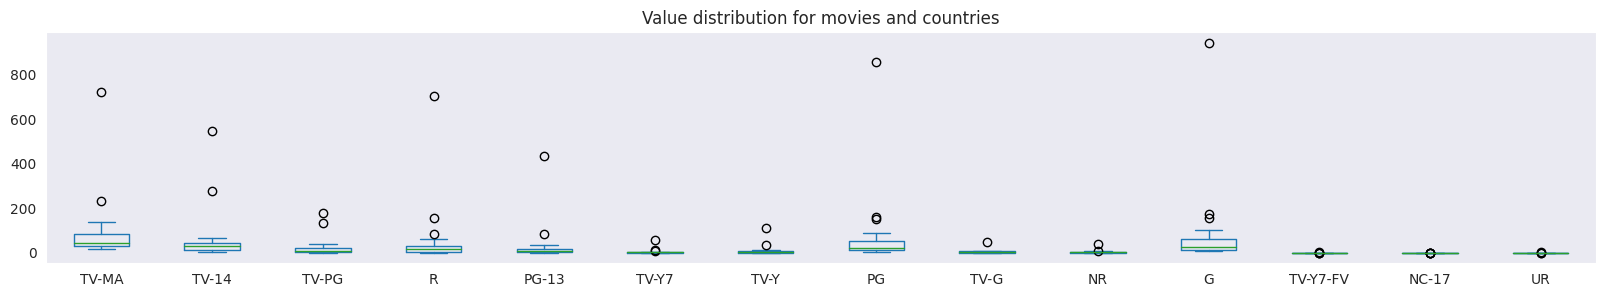

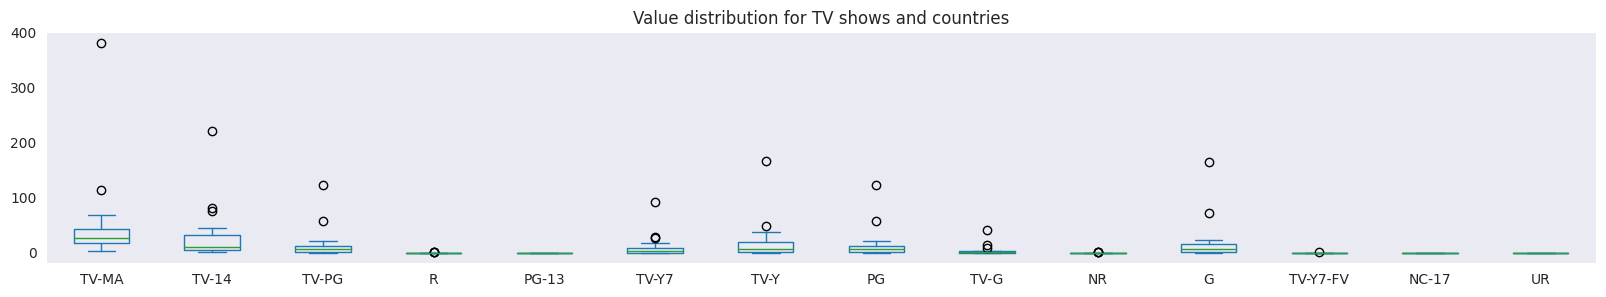

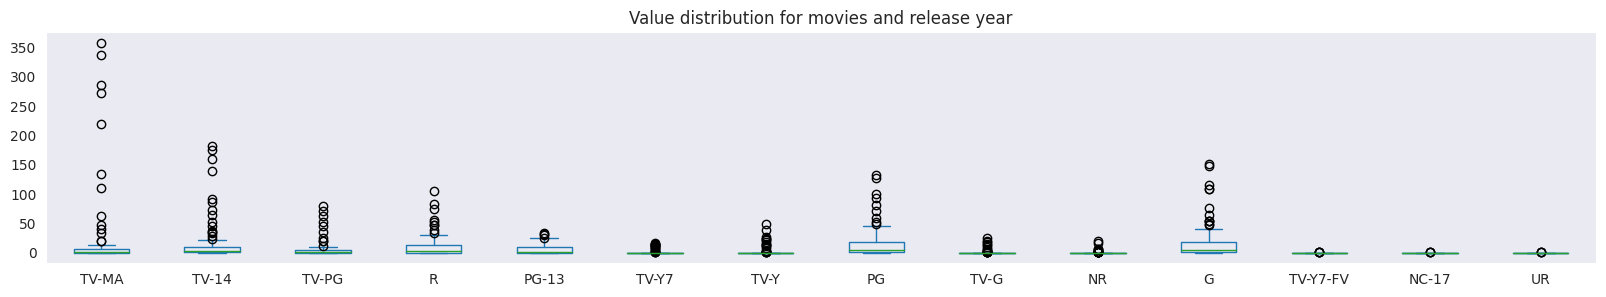

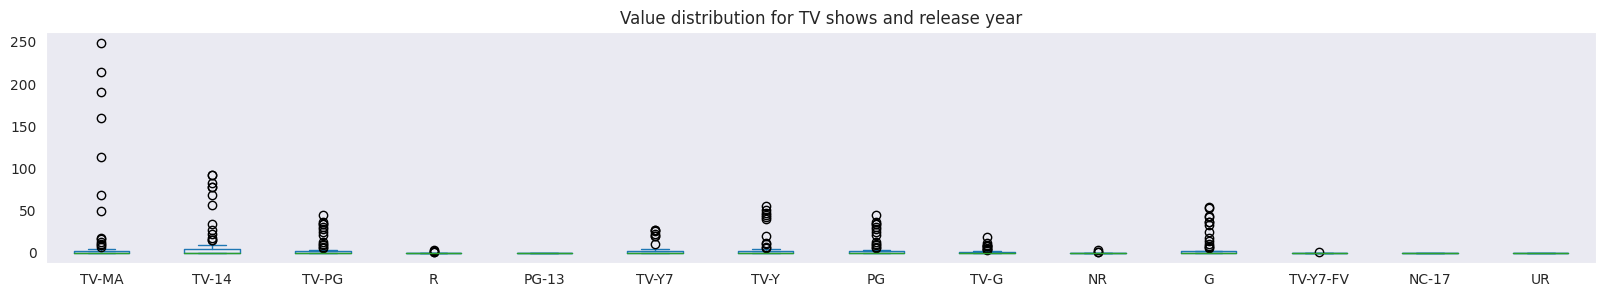

In [30]:
rating_m.T.plot(kind="box", figsize=(20,3), title="Value distribution for movies and countries");
rating_t.T.plot(kind="box", figsize=(20,3), title="Value distribution for TV shows and countries");
rating_m_y.T.plot(kind="box", figsize=(20,3), title="Value distribution for movies and release year");
rating_t_y.T.plot(kind="box", figsize=(20,3), title="Value distribution for TV shows and release year");

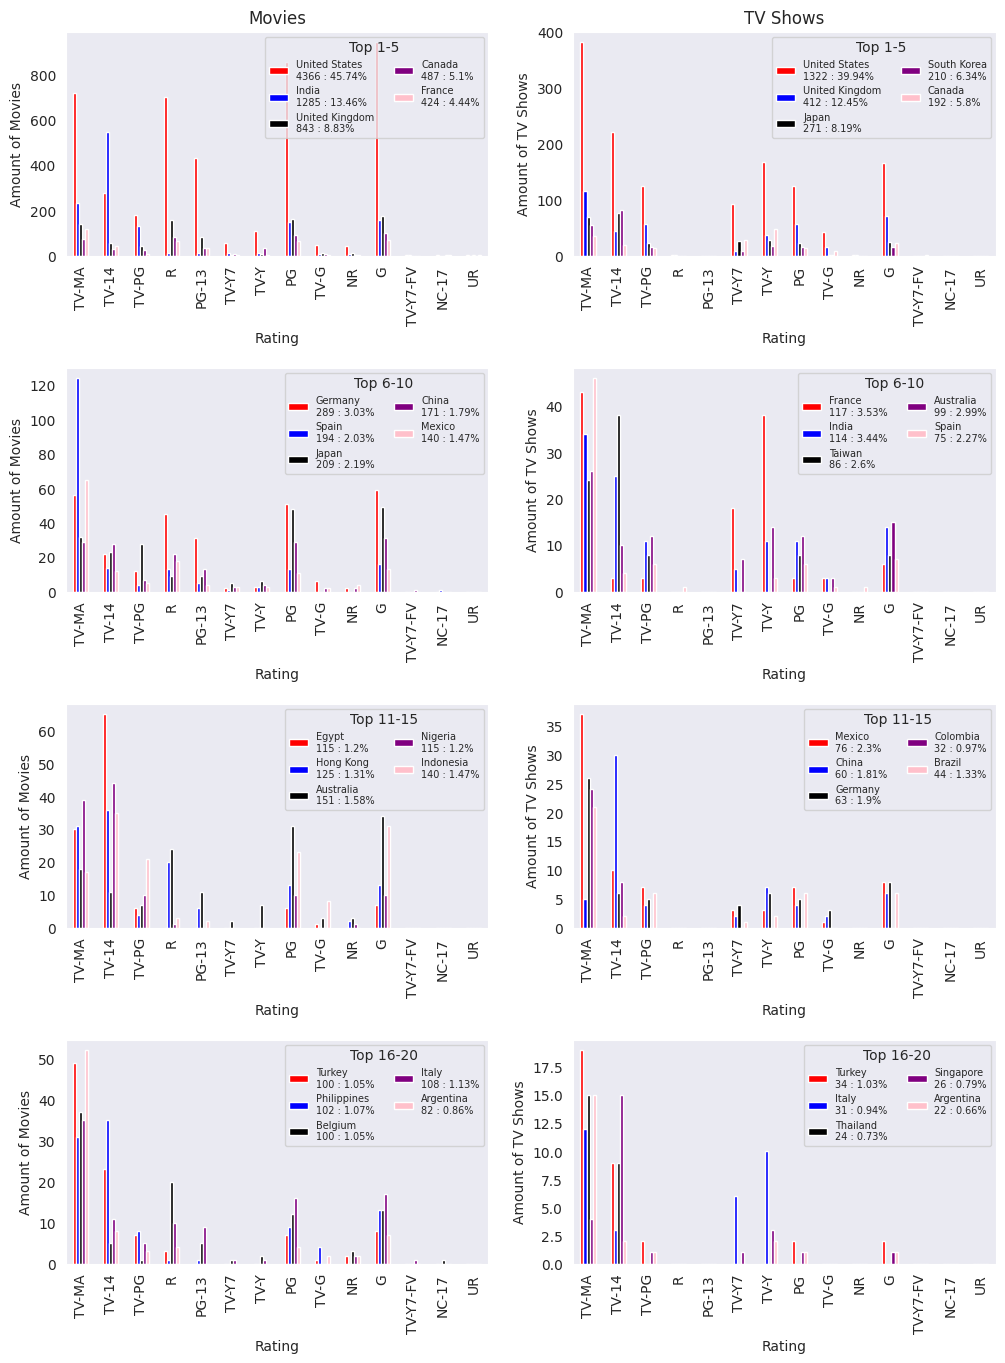

In [31]:
fig, axs = plt.subplots(4, 2, figsize=(12,16))
fig.subplots_adjust(hspace=0.5)

plot_area(axs=axs, kind="bar", loc="best", rot=90, data=rating_m.copy(), step=5, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Rating", colors=colors)
plot_area(axs=axs, kind="bar", loc="best", rot=90, data=rating_t.copy(), step=5, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Rating", colors=colors)

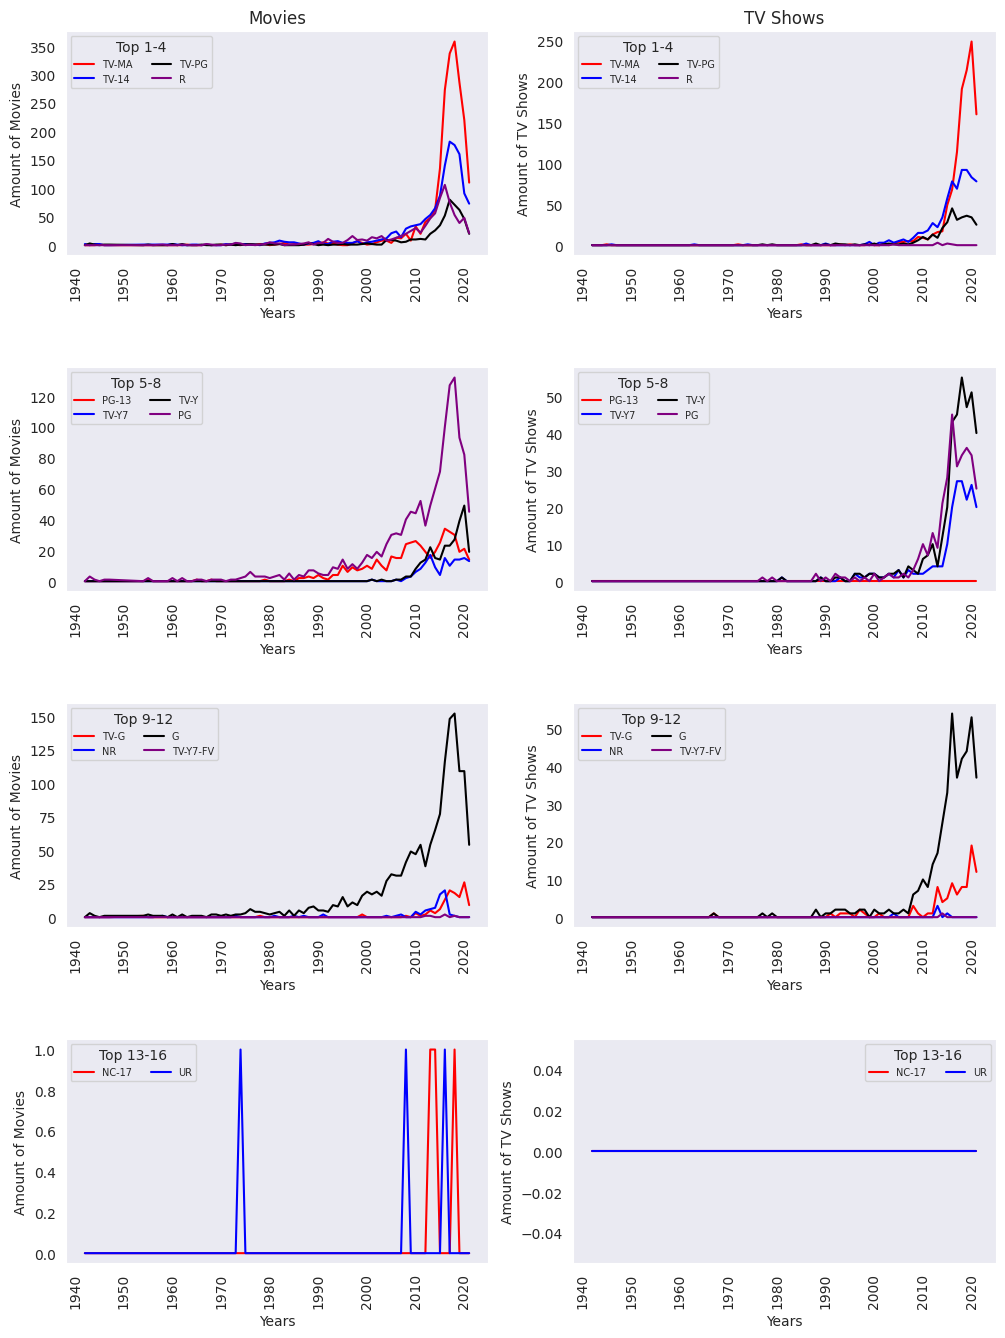

In [32]:
fig, axs = plt.subplots(4, 2, figsize=(12,16))
fig.subplots_adjust(hspace=0.5)

plot_area(axs=axs, kind="line", loc="best", rot=90, data=rating_m_y.T.copy(), step=4, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Years", colors=colors, show_labels=False)
plot_area(axs=axs, kind="line", loc="best", rot=90, data=rating_t_y.T.copy(), step=4, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Years", colors=colors, show_labels=False)

### Now let's look into the prepared data about other things

### Looking at the graph below we can see some intresting information about mean duration of movies and TV Show based on their genre.
Data differ quite heavily from one to other, which is quite intresting and can be used in the future in some kind of machine learning algorith for recomendation system, as if user don't really watch long movies, we can recomend him to look Stand-Up Comedy and so on.

Same can be said about TV Shows.

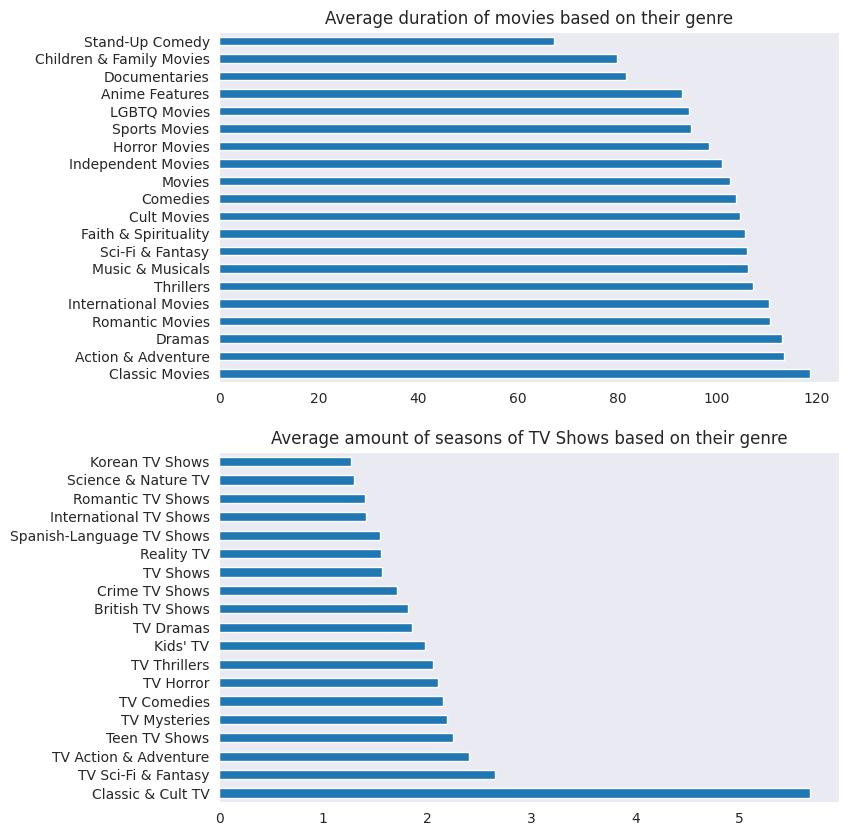

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(8,10))
axs = axs.ravel()

df_genre_time.sort_values(by="Mean Time", ascending=False, inplace=True)
df_genre_time_shows.sort_values(by="Mean Time", ascending=False , inplace=True)

df_genre_time.plot(ax=axs[0], kind="barh", legend=False, title="Average duration of movies based on their genre");
df_genre_time_shows.plot(ax=axs[1], kind="barh", legend=False, title="Average amount of seasons of TV Shows based on their genre");

### Now let's look at popularity of different movies and shows at different points of time
Here we are looking at the popularity under the assumption that market was providing customers with content they were most eager to watch, which can be wrong, but as we don't really have any other information, that would be our best bet

In [146]:
lol = df_genre_month.sum()
lol.name = "sum"
df_genre_month = df_genre_month.append(lol)
lol = df_genre_month_shows.sum()
lol.name = "sum"
df_genre_month_shows = df_genre_month_shows.append(lol)

/tmp/ipykernel_5748/3077822043.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_genre_month = df_genre_month.append(lol)
/tmp/ipykernel_5748/3077822043.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_genre_month_shows = df_genre_month_shows.append(lol)


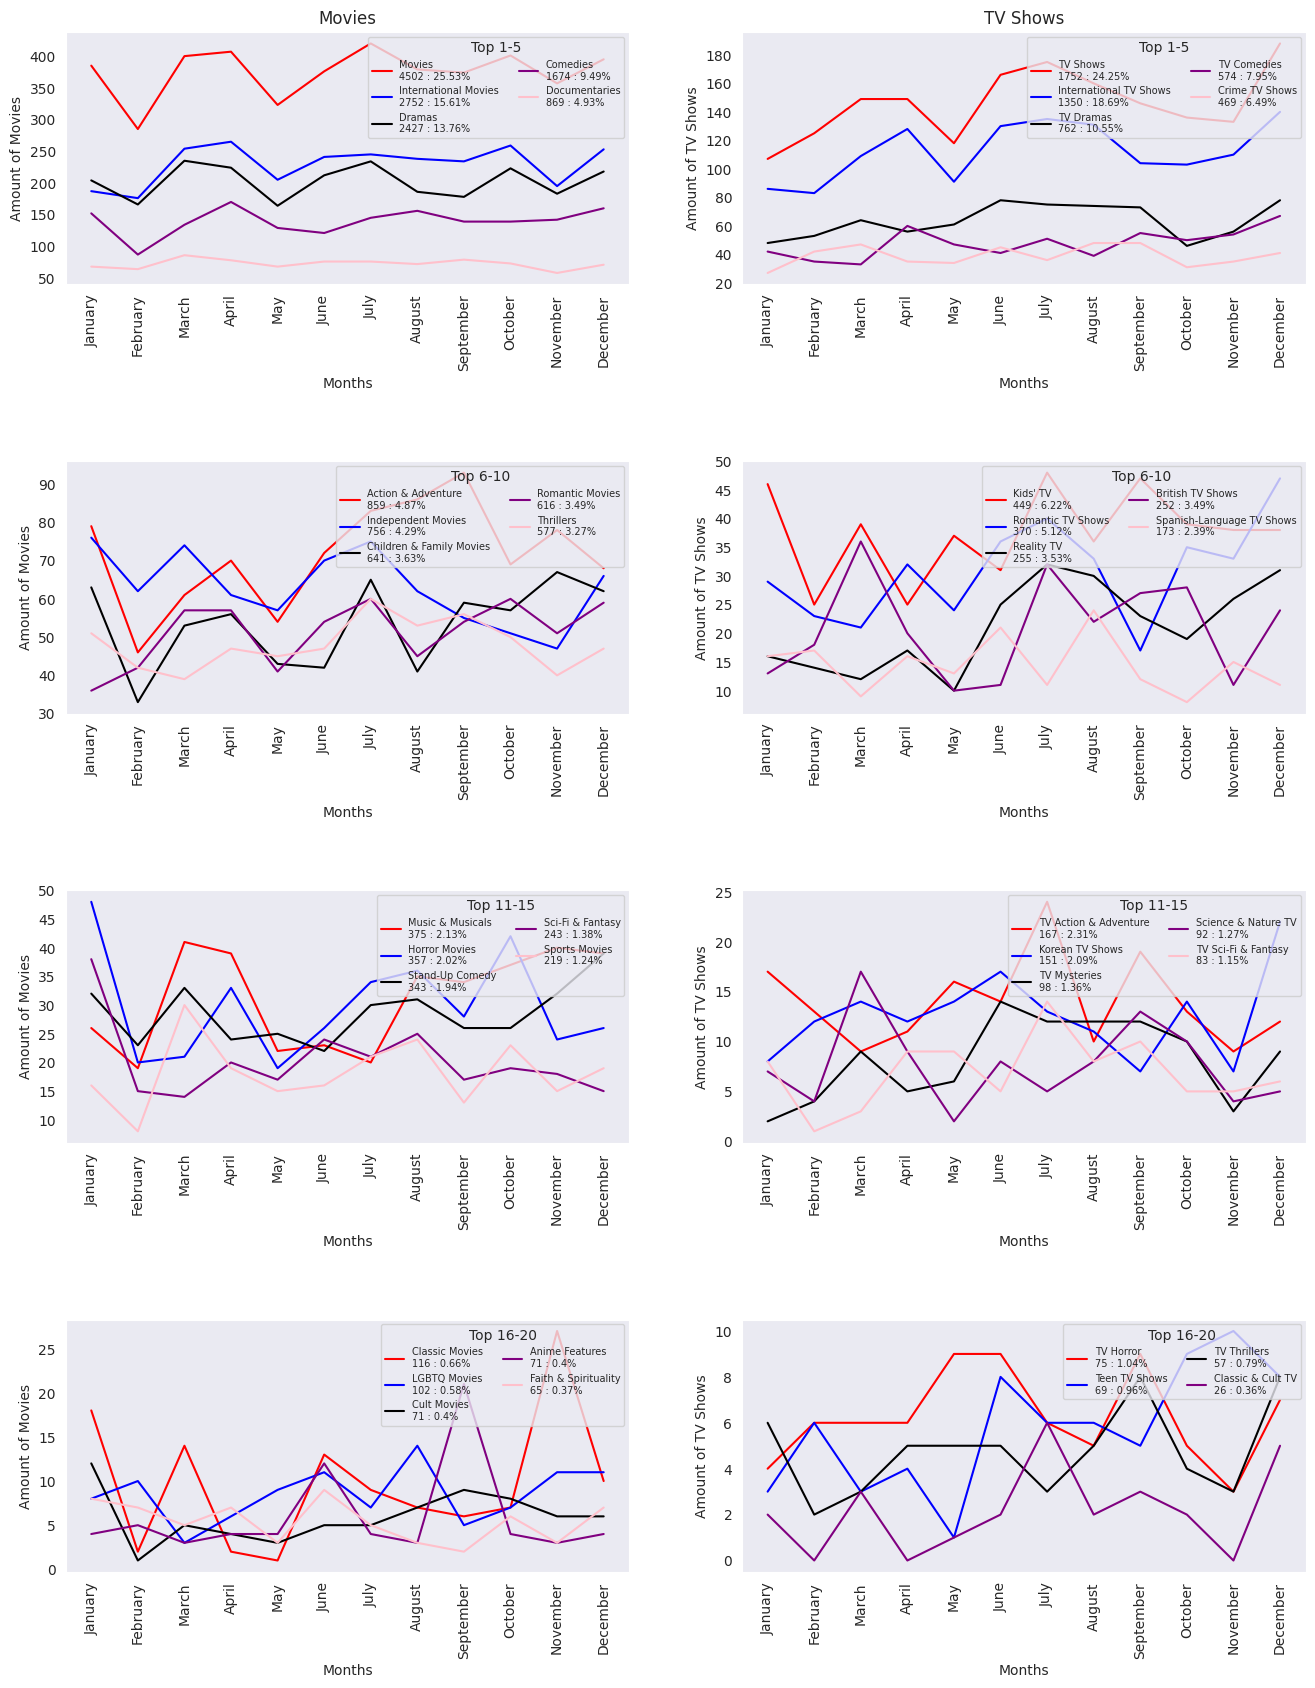

In [147]:
fig, axs = plt.subplots(4, 2, figsize=(16,20))
fig.subplots_adjust(hspace=0.7)
#months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

plot_area(axs=axs, kind="line", x_ticks=df_genre_month.index.values[:-1], data=df_genre_month.T.sort_values("sum", ascending = False).T.drop("sum", axis="rows"), loc=1, rot=90, step=5, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Months", colors=colors)
plot_area(axs=axs, kind="line", x_ticks=df_genre_month_shows.index.values[:-1], data=df_genre_month_shows.T.sort_values("sum", ascending = False).T.drop("sum", axis="rows"), loc=1, rot=90, step=5, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Months", colors=colors)

In [39]:
df_genre_month_shows.drop("sum", axis="rows", inplace=True)
df_genre_month.drop("sum", axis="rows", inplace=True)

In [149]:
lol = df_genre_year.sum()
lol.name = "sum"
df_genre_year = df_genre_year.append(lol)
lol = df_genre_shows.sum()
lol.name = "sum"
df_genre_shows = df_genre_shows.append(lol)

/tmp/ipykernel_5748/2677751948.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_genre_year = df_genre_year.append(lol)
/tmp/ipykernel_5748/2677751948.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_genre_shows = df_genre_shows.append(lol)


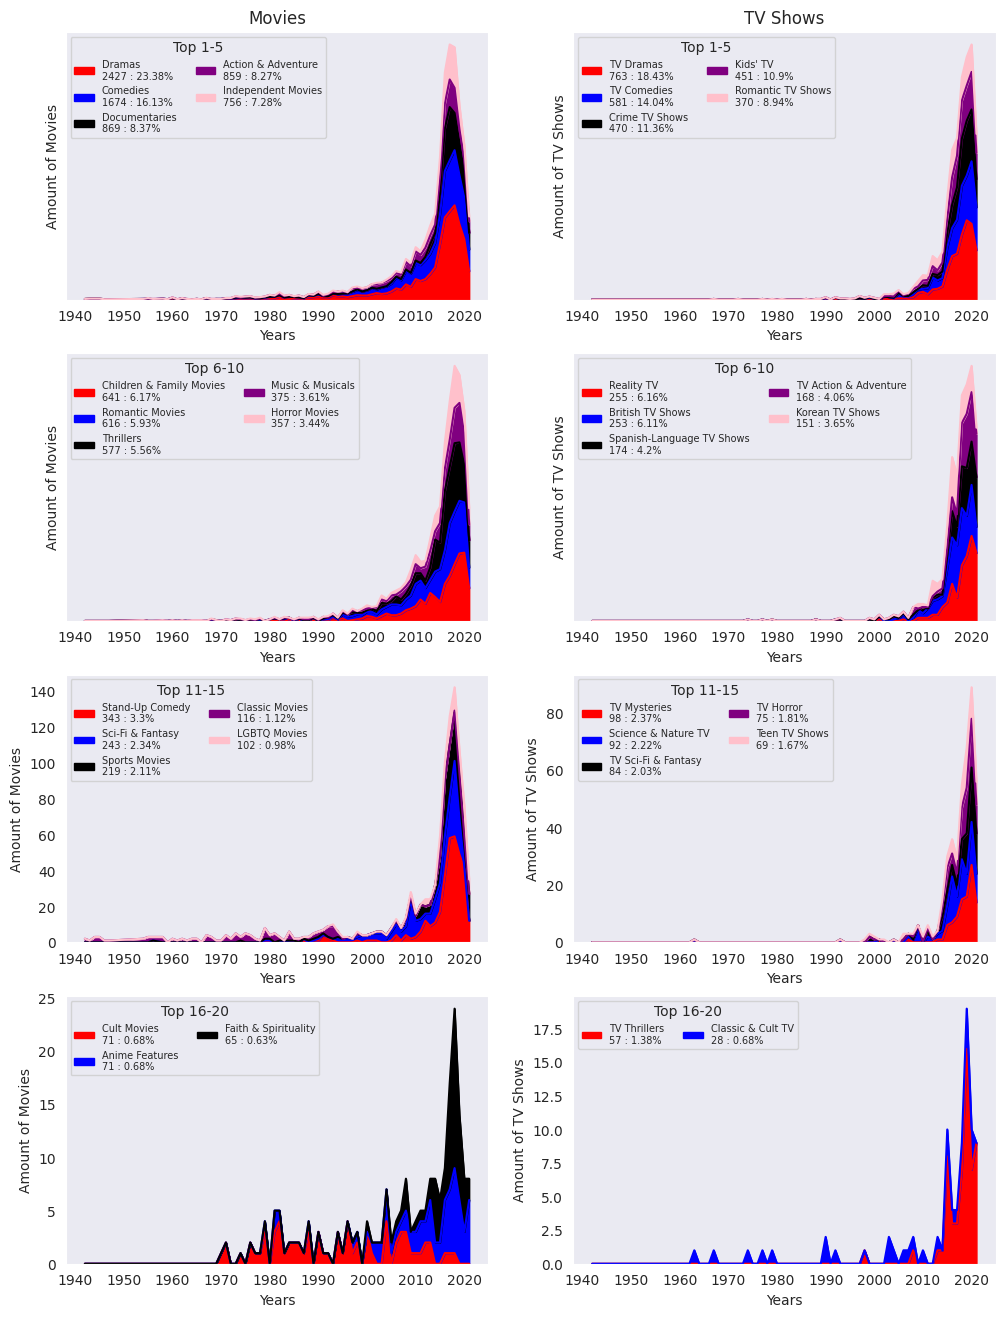

In [169]:
fig, axs = plt.subplots(4, 2, figsize=(12,16))

plot_area(axs=axs, data=df_genre_year.copy().T.sort_values("sum", ascending = False)[2:].T.drop("sum", axis="rows"), step=5, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Years", colors=colors)
plot_area(axs=axs, data=df_genre_shows.copy().T.sort_values("sum", ascending = False)[2:].T.drop("sum", axis="rows"), step=5, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Years", colors=colors)

In [120]:
df_genre_shows.drop("sum", axis="rows", inplace=True)
df_genre_year.drop("sum", axis="rows", inplace=True)

### Now let's do same with cast, directors and countrie

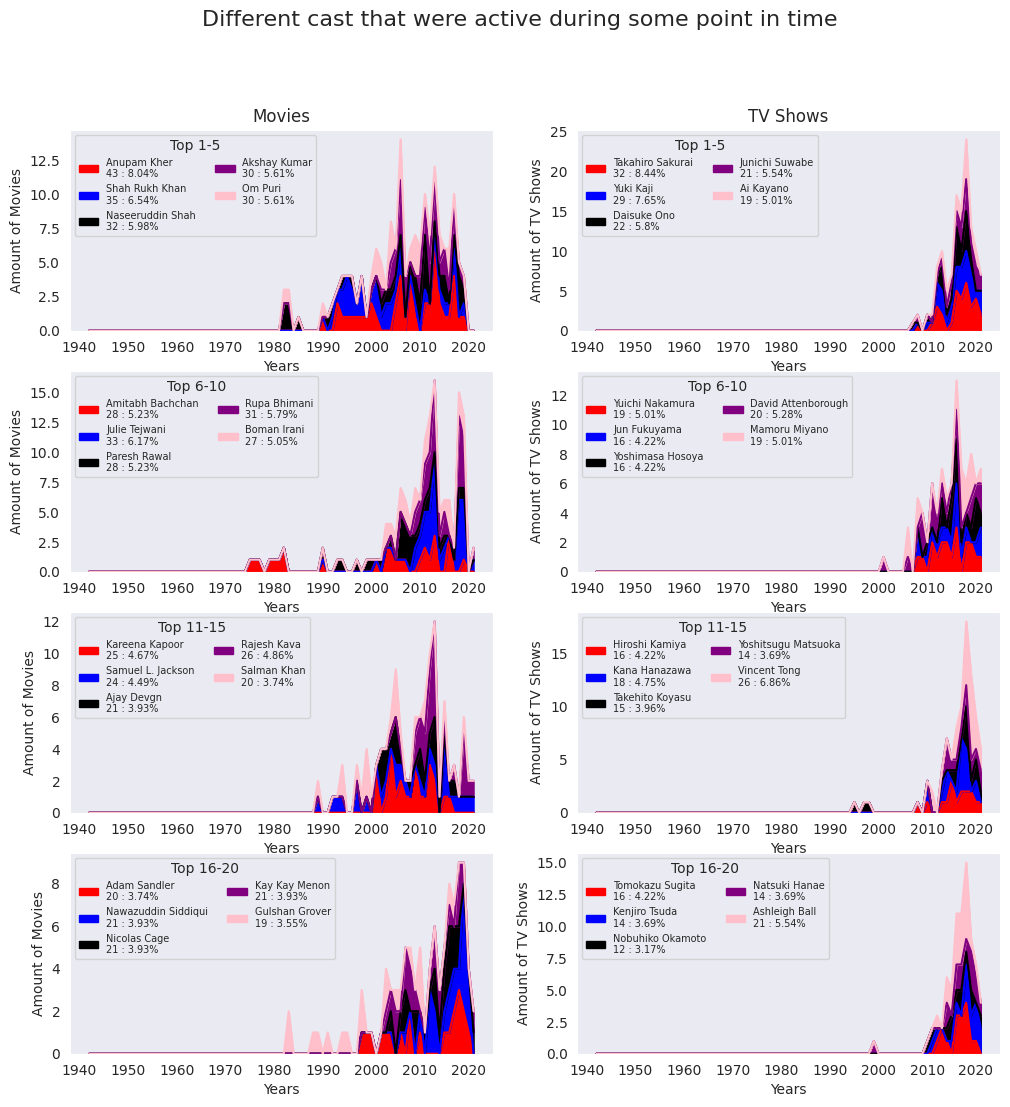

In [41]:
fig, axs = plt.subplots(4, 2, figsize=(12,12))
fig.suptitle('Different cast that were active during some point in time', fontsize=16)
plot_area(axs=axs, data=df_cast_movie.copy(), step=5, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Years", colors=colors)
plot_area(axs=axs, data=df_cast_show.copy(), step=5, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Years", colors=colors)

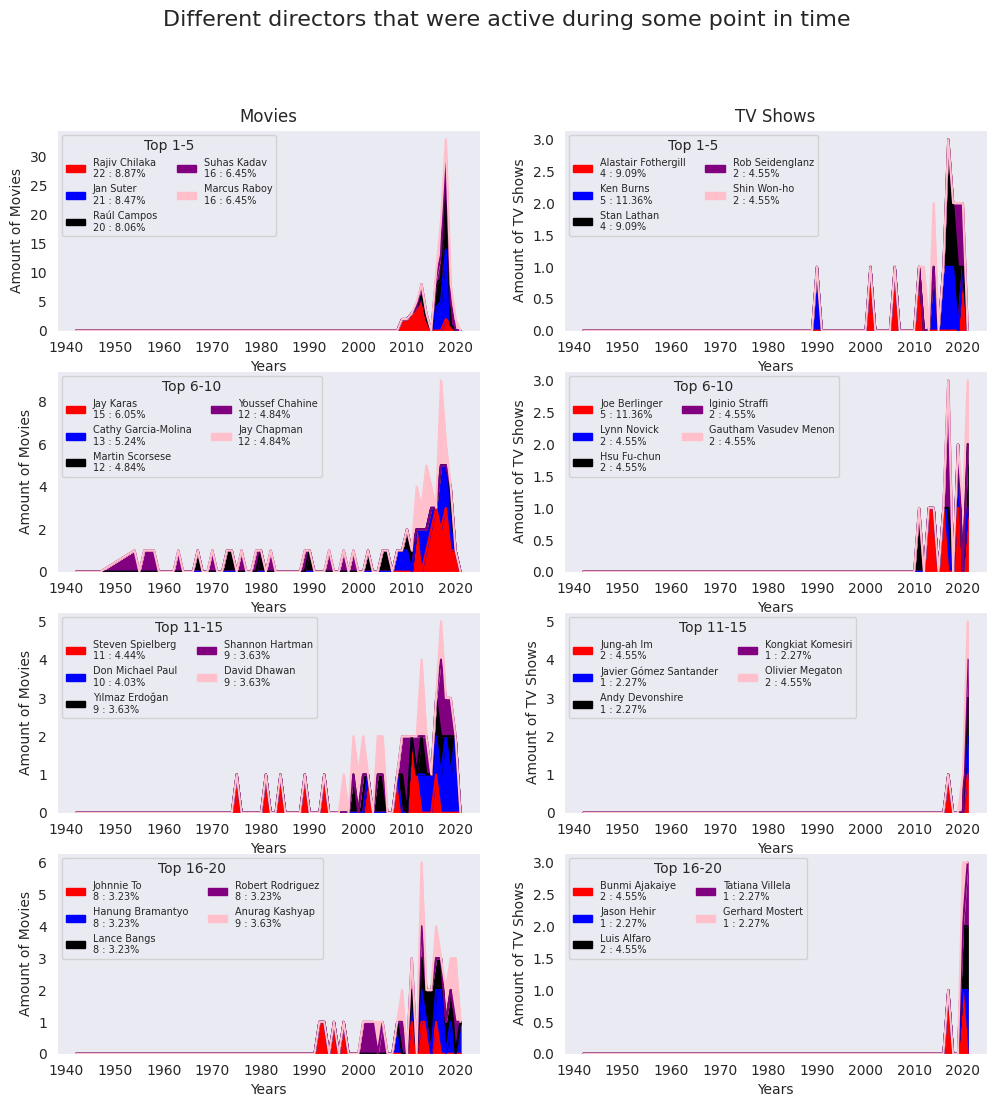

In [42]:
fig, axs = plt.subplots(4, 2, figsize=(12,12))
fig.suptitle('Different directors that were active during some point in time', fontsize=16)
plot_area(axs=axs, data=df_directors_movie.copy(), step=5, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Years", colors=colors)
plot_area(axs=axs, data=df_directors_show.copy(), step=5, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Years", colors=colors)

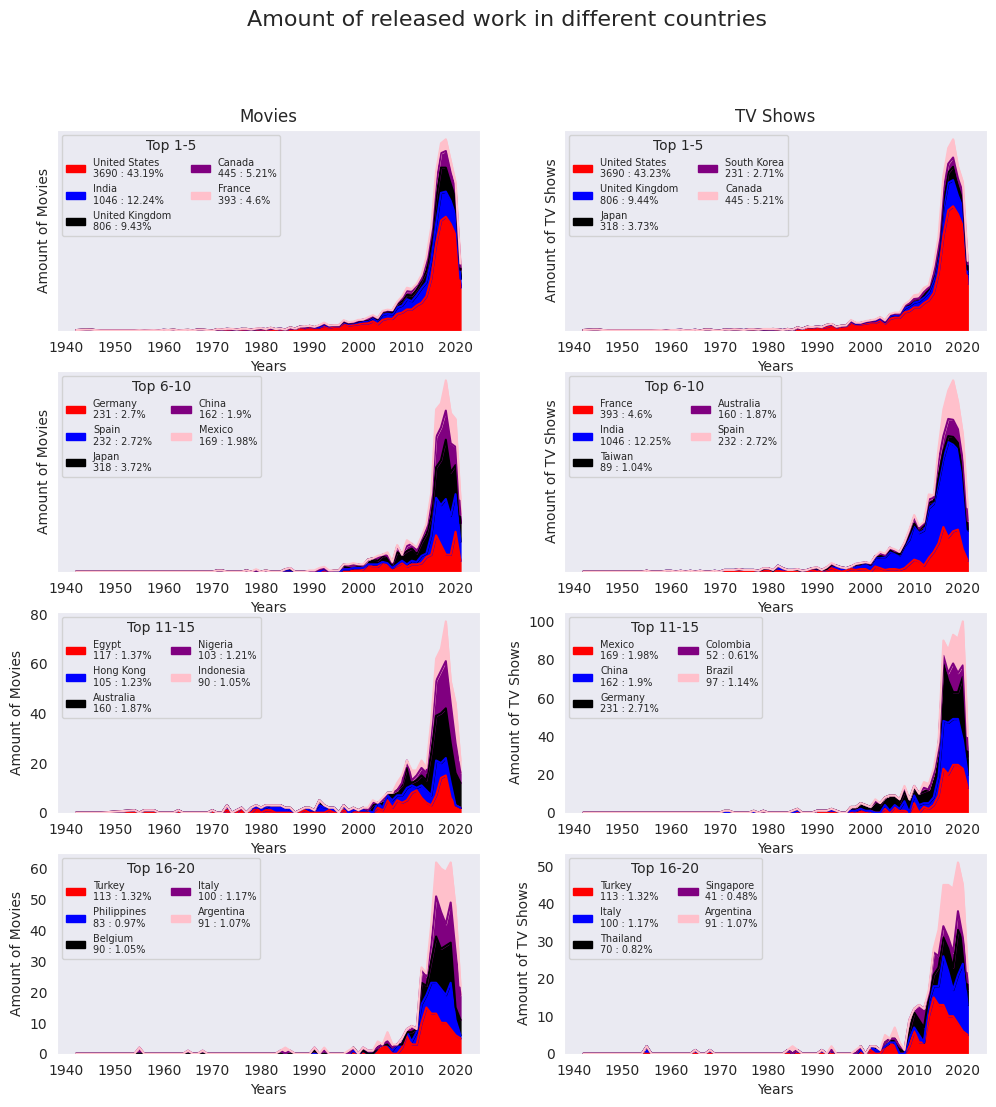

In [170]:
fig, axs = plt.subplots(4, 2, figsize=(12,12))
fig.suptitle('Amount of released work in different countries', fontsize=16)

plot_area(axs=axs, data=df_country_movie.copy(), step=5, n_cat=1, num_cat=2, title="Movies", y_label="Amount of Movies", x_label="Years", colors=colors)
plot_area(axs=axs, data=df_country_show.copy(), step=5, n_cat=2, num_cat=2, title="TV Shows", y_label="Amount of TV Shows", x_label="Years", colors=colors)

### All of that information was actually quite useful in many ways, such as in case of cast we were able to determine for example that even though some people took part in producing lots of movies they were not particulary popular all the time or vice versa they were popular only for a pair of years.

In [63]:
df_country_genre_movie.max()

United States     1470.0
India              926.0
United Kingdom     329.0
Canada             235.0
France             269.0
Germany            140.0
Spain              160.0
Japan              104.0
China               92.0
Mexico              85.0
Egypt              102.0
Hong Kong           91.0
Australia           68.0
Nigeria             93.0
Indonesia           84.0
Turkey              83.0
Philippines         80.0
Belgium             73.0
Italy               63.0
Argentina           63.0
dtype: float64

In [81]:
df_country_genre_movie

,United States,India,United Kingdom,Canada,France,Germany,Spain,Japan,China,Mexico,Egypt,Hong Kong,Australia,Nigeria,Indonesia,Turkey,Philippines,Belgium,Italy,Argentina
Cult Movies,52.0,5.0,7.0,6.0,2.0,4.0,0.0,1.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Action & Adventure,498.0,142.0,93.0,56.0,43.0,35.0,14.0,62.0,70.0,16.0,15.0,66.0,15.0,4.0,6.0,10.0,5.0,14.0,6.0,3.0
Anime Features,7.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comedies,938.0,349.0,135.0,124.0,75.0,49.0,52.0,19.0,43.0,28.0,61.0,34.0,32.0,43.0,16.0,61.0,29.0,20.0,15.0,16.0
Classic Movies,81.0,11.0,16.0,0.0,6.0,1.0,1.0,3.0,0.0,1.0,8.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0
Sports Movies,113.0,17.0,21.0,13.0,12.0,5.0,5.0,1.0,1.0,3.0,2.0,1.0,8.0,0.0,4.0,2.0,1.0,0.0,4.0,6.0
Sci-Fi & Fantasy,241.0,15.0,39.0,37.0,11.0,14.0,11.0,9.0,16.0,7.0,1.0,4.0,11.0,0.0,2.0,0.0,0.0,4.0,1.0,1.0
Documentaries,512.0,27.0,128.0,42.0,44.0,22.0,21.0,7.0,7.0,18.0,2.0,1.0,15.0,2.0,2.0,0.0,1.0,7.0,17.0,10.0
Children & Family Movies,390.0,26.0,46.0,80.0,23.0,18.0,9.0,19.0,16.0,5.0,1.0,3.0,19.0,0.0,6.0,2.0,2.0,7.0,3.0,3.0
Thrillers,319.0,95.0,63.0,54.0,47.0,29.0,38.0,11.0,6.0,2.0,4.0,3.0,11.0,16.0,0.0,7.0,3.0,11.0,9.0,8.0


## Now why not look deeper at what is the most popular genre in different countries?

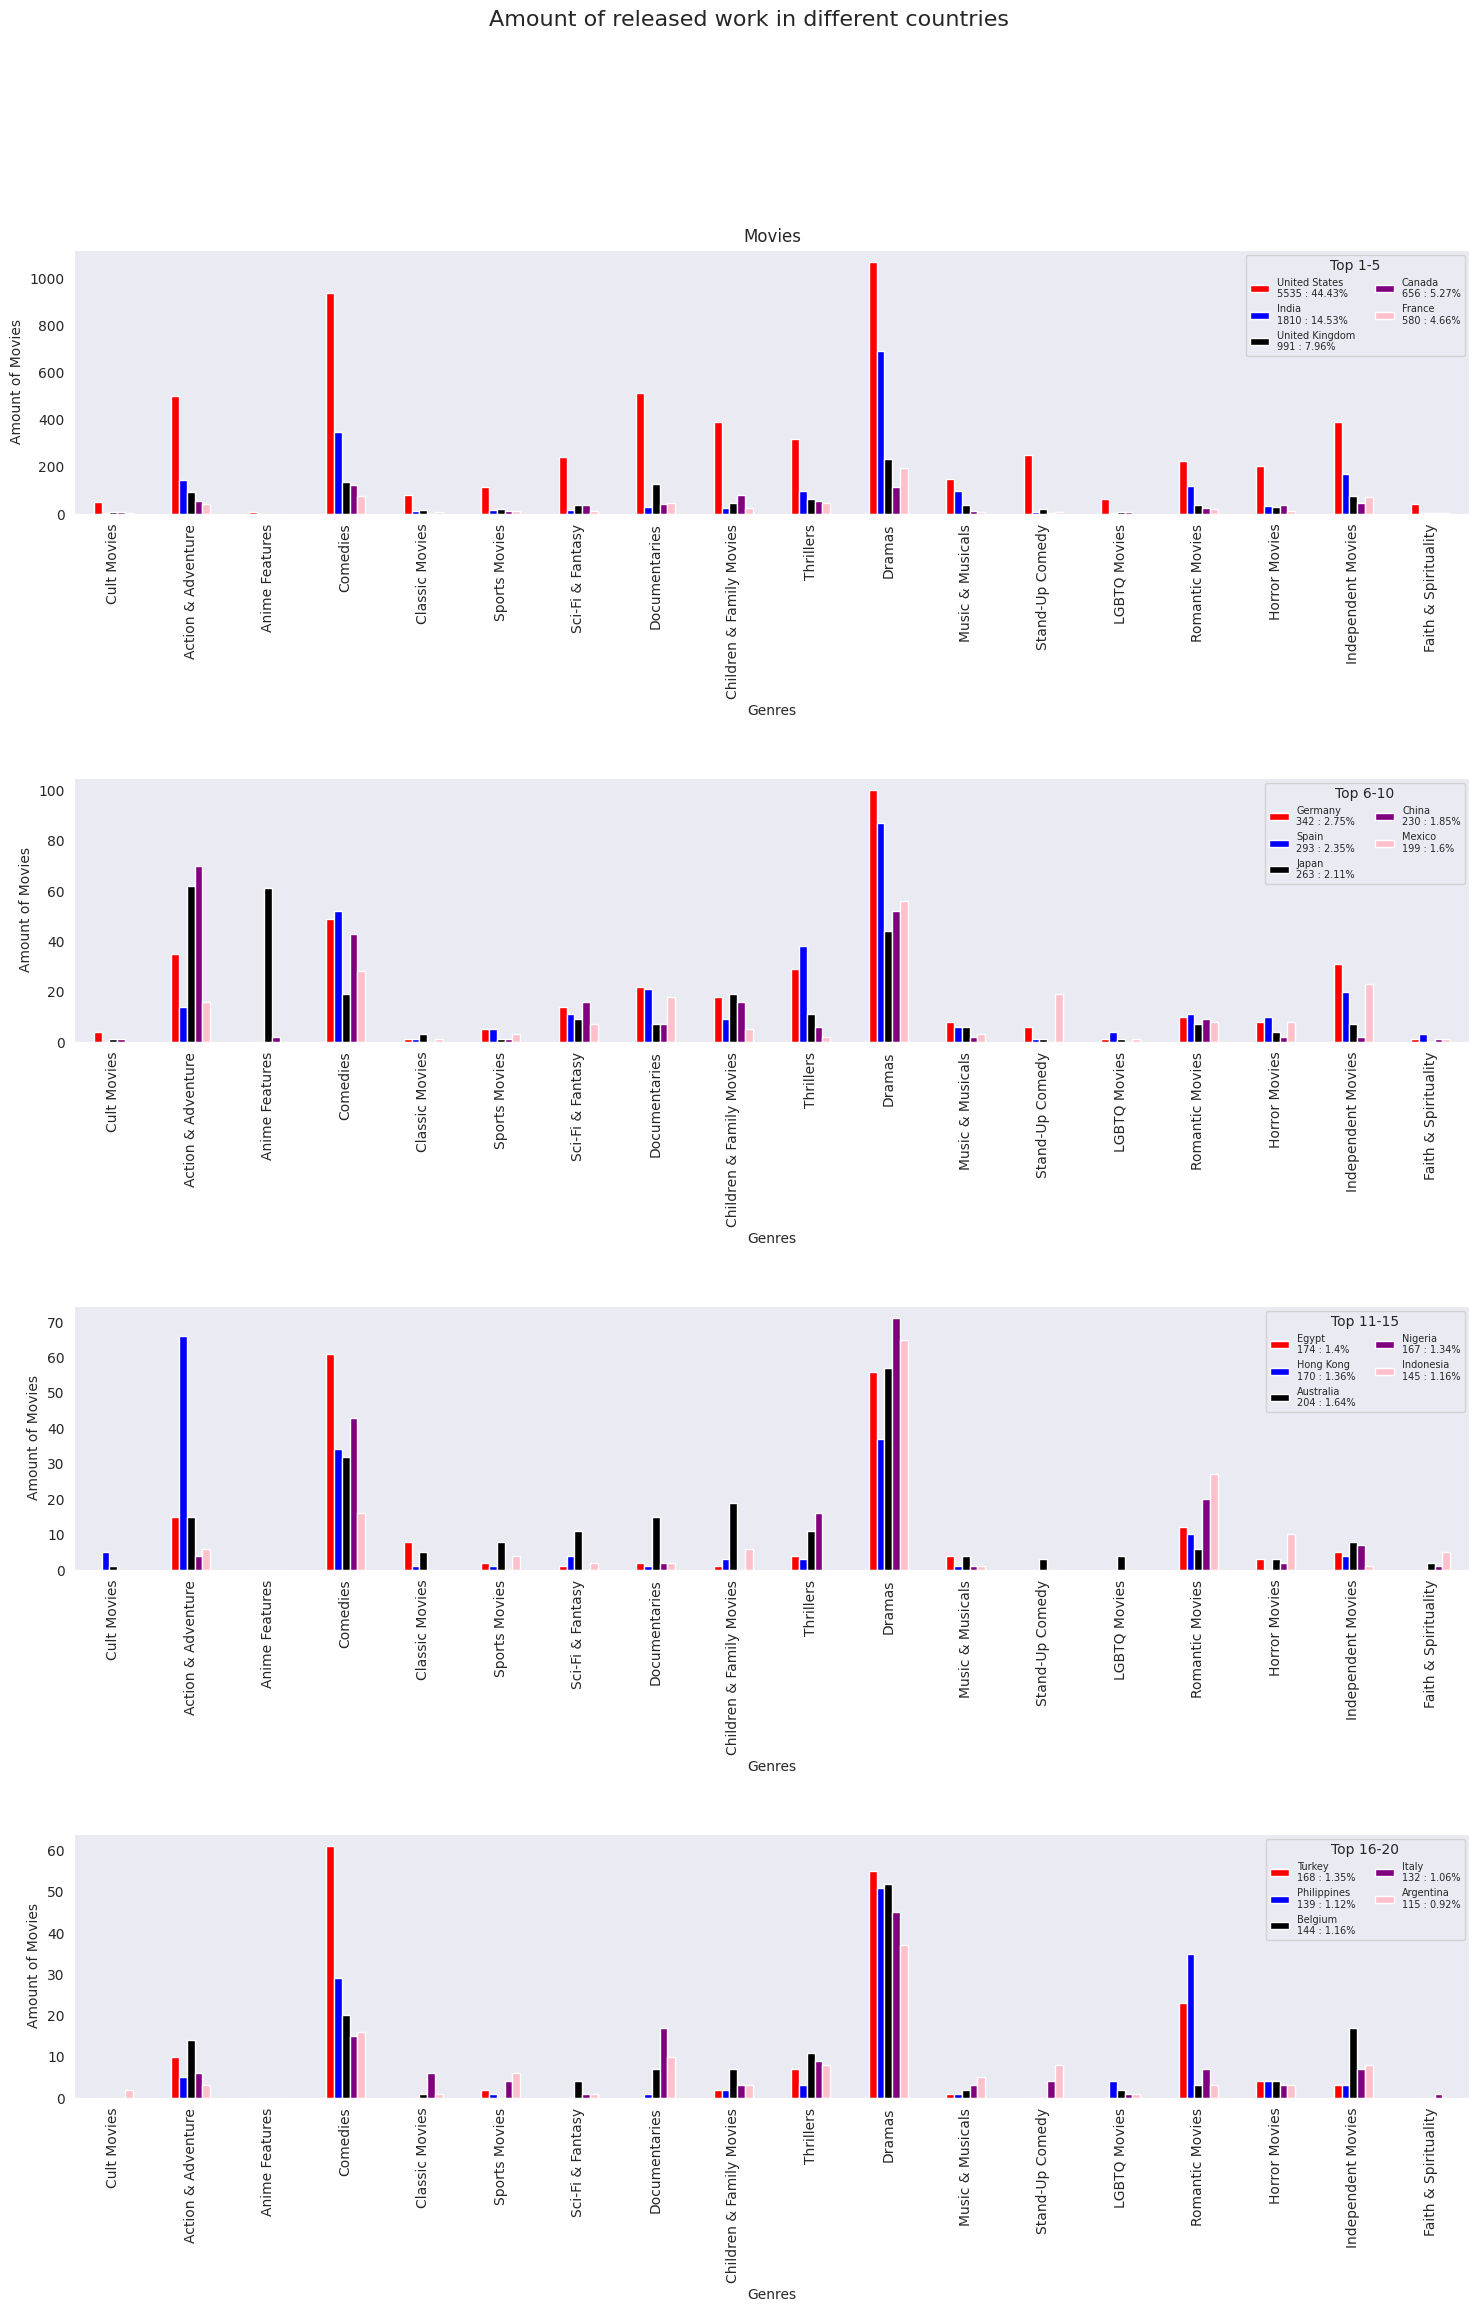

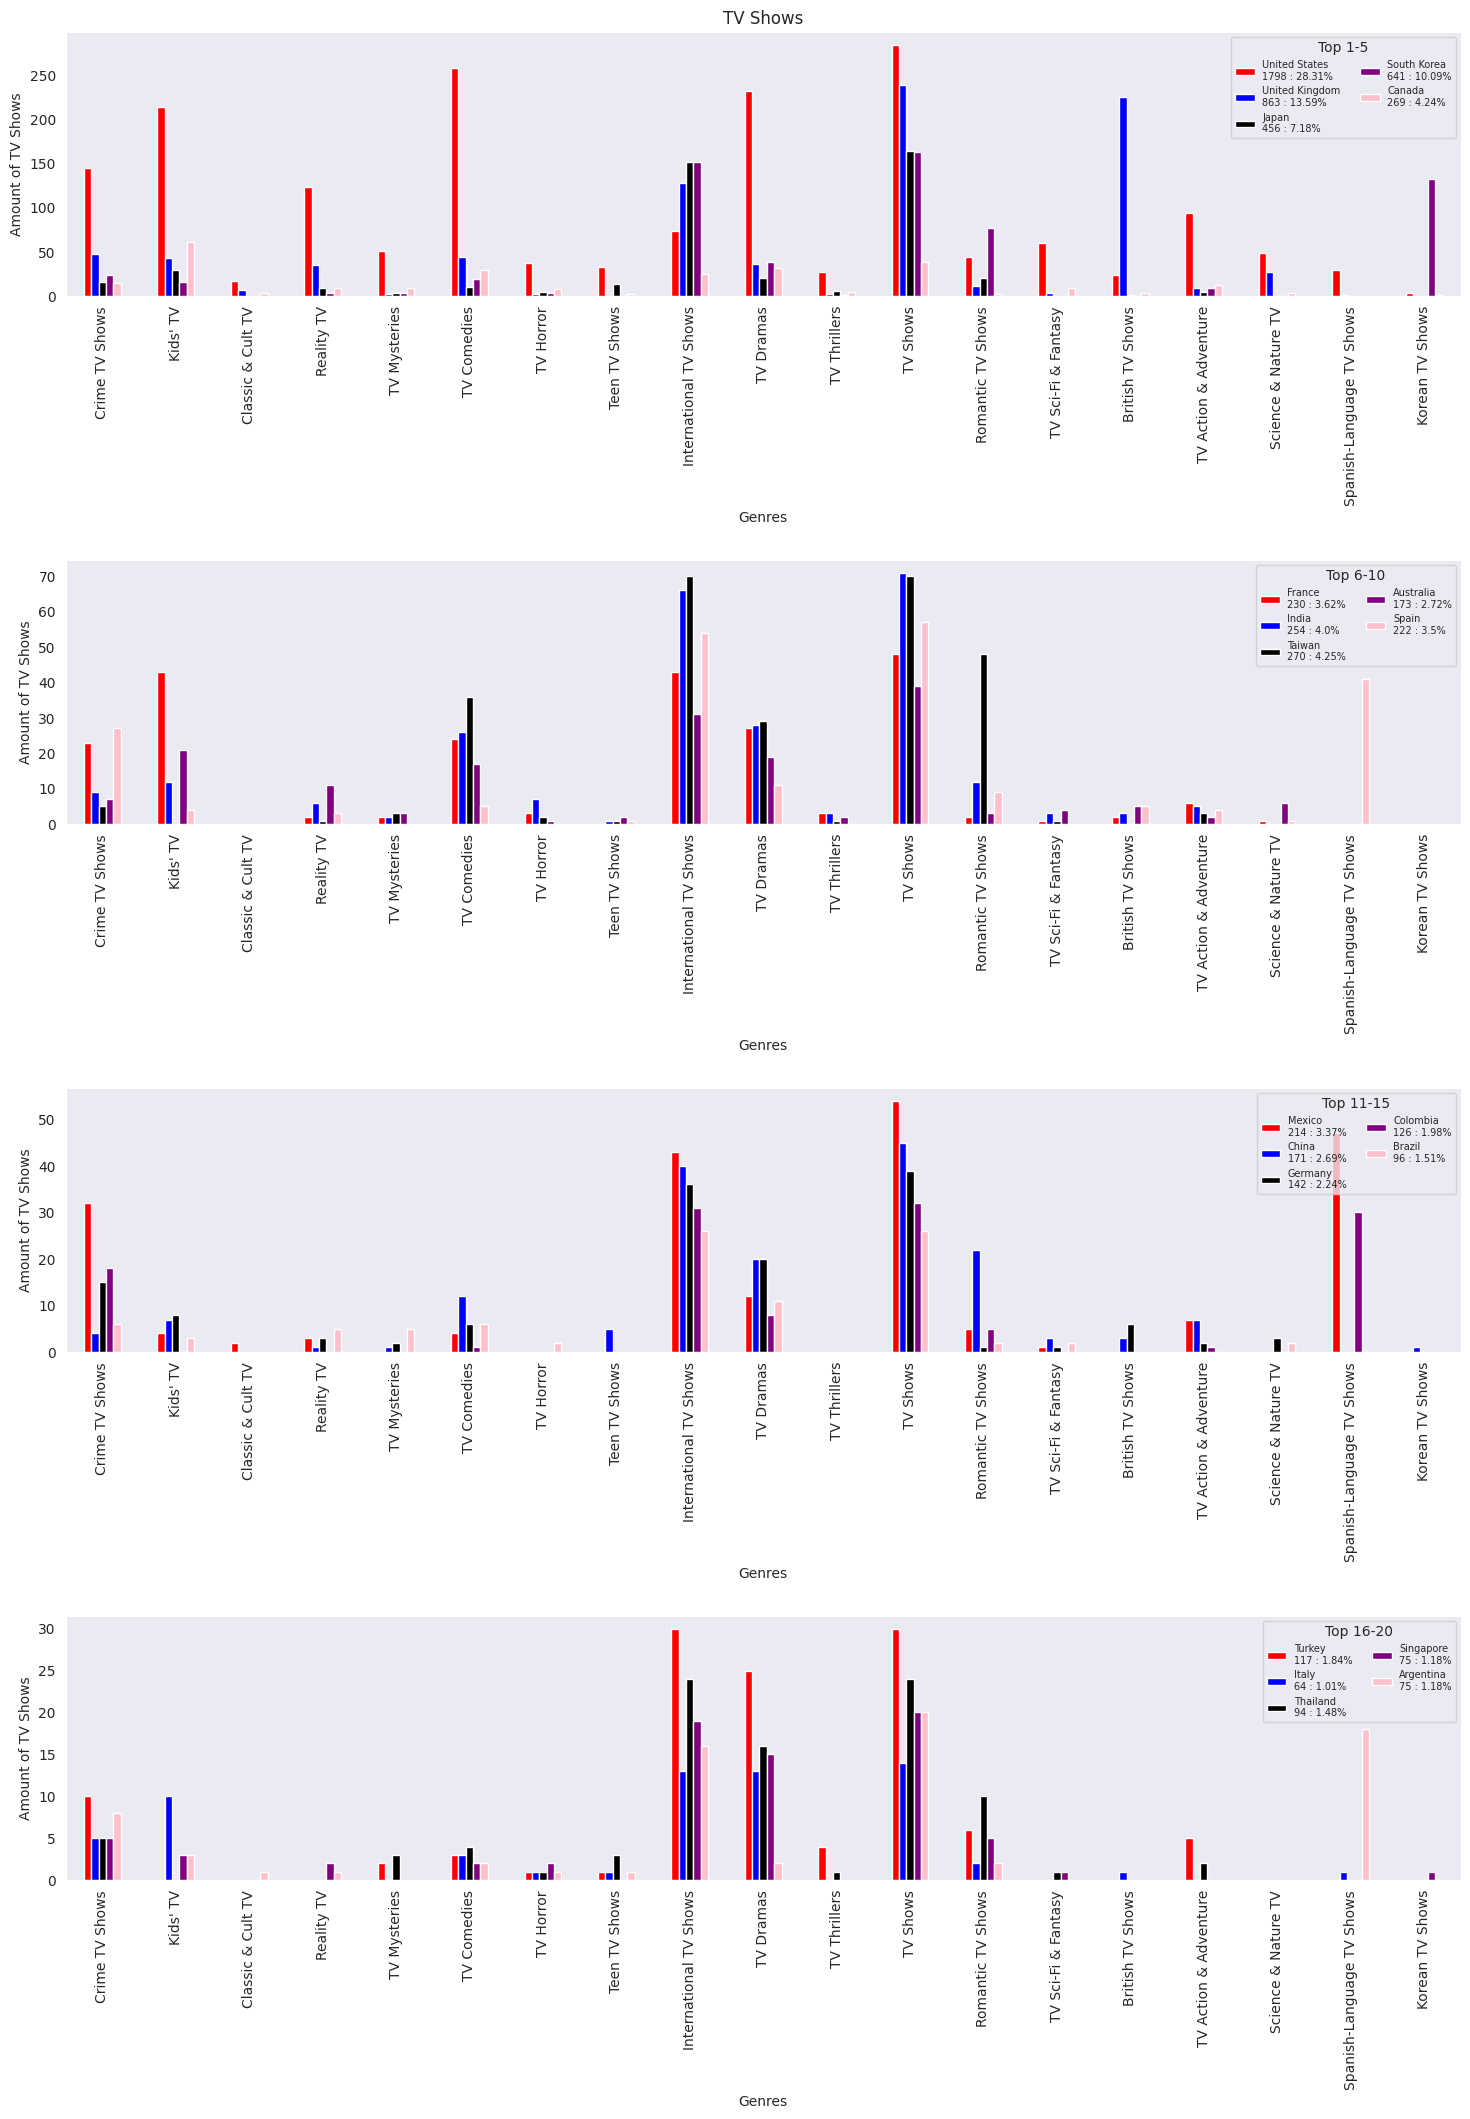

In [121]:
fig, axs = plt.subplots(4, 1, figsize=(18,24))
fig.suptitle('Amount of released work in different countries', fontsize=16)
fig.subplots_adjust(hspace=1)

plot_area(axs=axs, kind="bar", loc=1, rot=90, data=df_country_genre_movie.copy(), step=5, n_cat=1, num_cat=1, title="Movies", y_label="Amount of Movies", x_label="Genres", colors=colors)

fig, axs = plt.subplots(4, 1, figsize=(18,24))
fig.subplots_adjust(hspace=1)

plot_area(axs=axs, kind="bar", loc=1, rot=90, data=df_country_genre_show.copy(), step=5, n_cat=1, num_cat=1, title="TV Shows", y_label="Amount of TV Shows", x_label="Genres", colors=colors)

In [4]:
genre = "LGBTQ Movies"

In [10]:
pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][2000].nlargest(n=1).index[0]

KeyError: 2000

In [424]:
df_genre_month.columns

Index(['Cult Movies', 'Action & Adventure', 'Anime Features', 'Comedies',
       'Classic Movies', 'Sports Movies', 'Sci-Fi & Fantasy', 'Documentaries',
       'Children & Family Movies', 'Thrillers', 'Dramas', 'Music & Musicals',
       'Stand-Up Comedy', 'Movies', 'LGBTQ Movies', 'Romantic Movies',
       'Horror Movies', 'Independent Movies', 'International Movies',
       'Faith & Spirituality'],
      dtype='object')

In [23]:
lel = pd.DataFrame(index=release_year.index, columns=df_genre_month[:-1].index).fillna(0)
genre = "LGBTQ Movies"
for i in lel.index:
    try:
        lel[pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][i].nlargest(n=1).index[0]][i] = 1
    except:
        pass

NameError: name 'df_genre_month' is not defined

In [445]:
lel2 = pd.DataFrame(index=release_year.index, columns=df_genre_month[:-1].index).fillna(0)
genre2 = "Horror Movies"
for i in lel2.index:
    try:
        lel2[pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre2) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][i].nlargest(n=1).index[0]][i] = 1
    except:
        pass

In [458]:
lel3 = pd.DataFrame(index=release_year.index, columns=df_genre_month[:-1].index).fillna(0)
genre3 = "Comedies"
for i in lel3.index:
    try:
        lel3[pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre3) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][i].nlargest(n=1).index[0]][i] = 1
    except:
        pass

In [459]:
lel4 = pd.DataFrame(index=release_year.index, columns=df_genre_month[:-1].index).fillna(0)
genre4 = "Thrillers"
for i in lel4.index:
    try:
        lel4[pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre4) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][i].nlargest(n=1).index[0]][i] = 1
    except:
        pass

In [471]:
lel5 = pd.DataFrame(index=release_year.index, columns=df_genre_month[:-1].index).fillna(0)
genre5 = "Sports Movies"
for i in lel5.index:
    try:
        lel5[pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre5) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][i].nlargest(n=1).index[0]][i] = 1
    except:
        pass

In [469]:
lel6 = pd.DataFrame(index=release_year.index, columns=df_genre_month[:-1].index).fillna(0)
genre6 = "Anime Features"
for i in lel6.index:
    try:
        lel6[pd.DataFrame(df[["month_added", "release_year"]].where((df["type"] == "Movie") & (df["listed_in"].str.find(genre6) > -1)).dropna().value_counts()).unstack().unstack().unstack().T[0][i].nlargest(n=1).index[0]][i] = 1
    except:
        pass

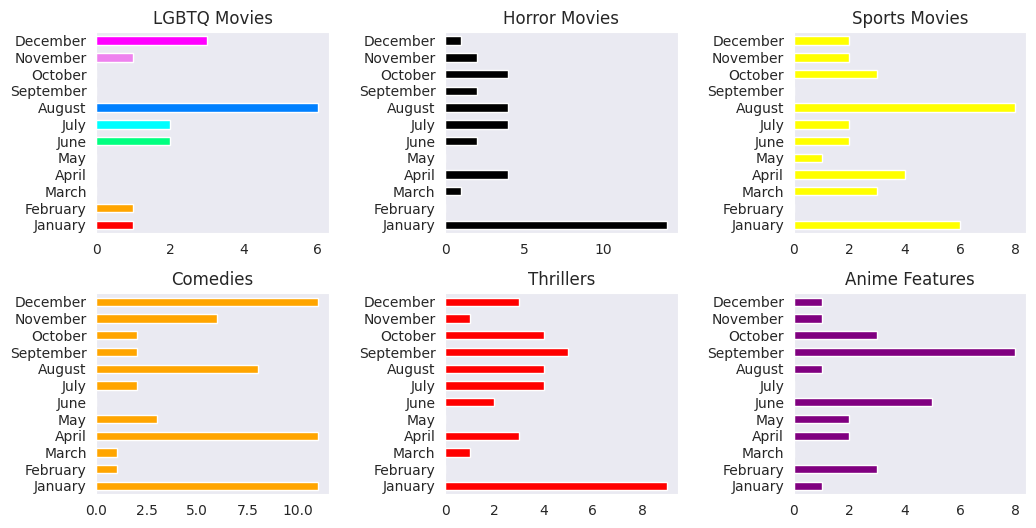

In [482]:
fig, axs = plt.subplots(2, 3, figsize=(12,6))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.3)

lel.sum().plot(ax=axs[0,0], kind="barh", title=genre, color=["red", "orange", "yellow", "#80ff00", "green", "#00ff80", "cyan", "#0080ff", "blue", "purple", "violet", "magenta"]);
lel2.sum().plot(ax=axs[0,1], kind="barh", title=genre2, color="black");
lel3.sum().plot(ax=axs[1,0], kind="barh", title=genre3, color="orange");
lel4.sum().plot(ax=axs[1,1], kind="barh", title=genre4, color="red");
lel5.sum().plot(ax=axs[0,2], kind="barh", title=genre5, color="yellow");
lel6.sum().plot(ax=axs[1,2], kind="barh", title=genre6, color="purple");

In [315]:
lol = []
for i in df_genre_year.columns:
    lol.append(df_genre_year[i][:-1].nlargest(n=5))

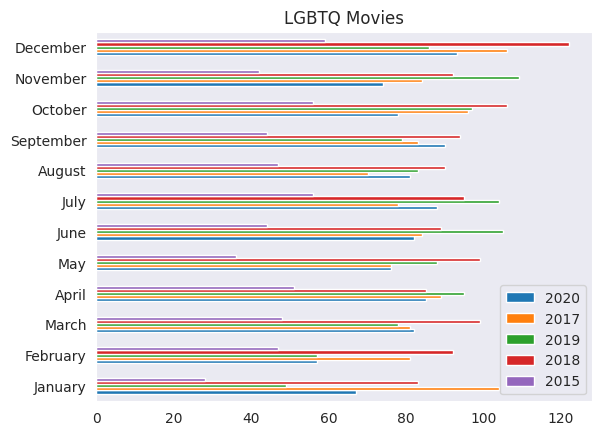

In [327]:
num = 14
lel = pd.DataFrame(index=df_genre_month.index, columns=lol[num].index).fillna(0)
for i in lel.columns:
    for j in lel.index[:-1]:
        if len(df["month_added"].where((df["month_added"] == j) & (df["release_year"] == i)).dropna().value_counts()) > 0:
            lel[i][j] += df["month_added"].where((df["month_added"] == j) & (df["release_year"] == i)).dropna().value_counts()
        lel = lel.fillna(0)
lel[:-1].plot(kind="barh", title = lol[num].name);

In [223]:
df["month_added"].where((df["month_added"] == "January") & (df["release_year"] == 2004)).dropna().value_counts()

January    9
Name: month_added, dtype: int64

In [403]:
release_year

2021    277
2020    517
2019    633
2018    767
2017    767
       ... 
1946      1
1945      3
1944      3
1943      3
1942      2
Name: release_year, Length: 73, dtype: int64

In [230]:
lel.index[:-1]

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object')

# DESCRIPTION AND TITLE

In [45]:
def look_into(data, what):
    buffer = ""
    for i in data.ents:
        if i.label_ == what:
            buffer += i.text + " "
    return buffer


df_m_desc = df["description"].where(df["type"] == "Movie").dropna().apply(lambda x: look_into(nlp(x), "ORG")).explode().value_counts()
df_t_desc = df["description"].where(df["type"] == "TV Show").dropna().apply(lambda x: look_into(nlp(x), "ORG")).explode().value_counts()

df_m_desc_person = df["description"].where(df["type"] == "Movie").dropna().apply(lambda x: look_into(nlp(x), "PERSON")).explode().value_counts()
df_t_desc_person = df["description"].where(df["type"] == "TV Show").dropna().apply(lambda x: look_into(nlp(x), "PERSON")).explode().value_counts()

df_m_desc_gpe = df["description"].where(df["type"] == "Movie").dropna().apply(lambda x: look_into(nlp(x), "GPE")).explode().value_counts()
df_t_desc_gpe = df["description"].where(df["type"] == "TV Show").dropna().apply(lambda x: look_into(nlp(x), "GPE")).explode().value_counts()

df_m_desc.drop("", inplace=True)
df_t_desc.drop("", inplace=True)
df_m_desc_person.drop("", inplace=True)
df_t_desc_person.drop("", inplace=True)
df_m_desc_gpe.drop("", inplace=True)
df_t_desc_gpe.drop("", inplace=True)

KeyboardInterrupt: 

In [ ]:
#df["title"]
df_m_title = df["title"].where(df["type"] == "Movie").dropna().apply(lambda x: look_into(nlp(x), "ORG")).explode().value_counts()
df_t_title = df["title"].where(df["type"] == "TV Show").dropna().apply(lambda x: look_into(nlp(x), "ORG")).explode().value_counts()

df_m_title_person = df["title"].where(df["type"] == "Movie").dropna().apply(lambda x: look_into(nlp(x), "PERSON")).explode().value_counts()
df_t_title_person = df["title"].where(df["type"] == "TV Show").dropna().apply(lambda x: look_into(nlp(x), "PERSON")).explode().value_counts()

df_m_title_gpe = df["title"].where(df["type"] == "Movie").dropna().apply(lambda x: look_into(nlp(x), "GPE")).explode().value_counts()
df_t_title_gpe = df["title"].where(df["type"] == "TV Show").dropna().apply(lambda x: look_into(nlp(x), "GPE")).explode().value_counts()

df_t_title.drop("", inplace=True)
df_m_title.drop("", inplace=True)
df_t_title_person.drop("", inplace=True)
df_m_title_person.drop("", inplace=True)
df_t_title_gpe.drop("", inplace=True)
df_m_title_gpe.drop("", inplace=True)

## Most popular words in description and titles

In [ ]:
fig, axs = plt.subplots(6,2, figsize=(18,16))
axs = axs.ravel()

fig.subplots_adjust(hspace=0.7)

df_m_desc[:10].plot(ax=axs[0], kind="barh", title="Top 10 most popular organisations in Movie's description");
df_t_desc[:10].plot(ax=axs[1], kind="barh", title="Top 10 most popular organisations in TV Show's description");

df_m_desc_person[:10].plot(ax=axs[2], kind="barh", title="Top 10 most popular names in Movie's description");
df_t_desc_person[:10].plot(ax=axs[3], kind="barh", title="Top 10 most popular names in TV Show's description");

df_m_desc_gpe[:10].plot(ax=axs[4], kind="barh", title="Top 10 most popular locations in Movie's description");
df_t_desc_gpe[:10].plot(ax=axs[5], kind="barh", title="Top 10 most popular locations in TV Show's description");

df_m_title[:10].plot(ax=axs[6], kind="barh", title="Top 10 most popular organisations in Movie's title");
df_t_title[:10].plot(ax=axs[7], kind="barh", title="Top 10 most popular organisations in TV Show's title");

df_m_title_person[:10].plot(ax=axs[8], kind="barh", title="Top 10 most popular names in Movie's title");
df_t_title_person[:10].plot(ax=axs[9], kind="barh", title="Top 10 most popular names in TV Show's title");

df_m_title_gpe[:10].plot(ax=axs[10], kind="barh", title="Top 10 most popular locations in Movie's title");
df_t_title_gpe[:10].plot(ax=axs[11], kind="barh", title="Top 10 most popular locations in TV Show's title");

## Now let's look at description of different countries

In [ ]:
country_desc_m = pd.DataFrame(index=df_country_movie.columns, columns=df_m_desc[:10].index, dtype="int32").fillna(0)
country_desc_t = pd.DataFrame(index=df_country_show.columns, columns=df_t_desc[:10].index, dtype="int32").fillna(0)

country_desc_m_p = pd.DataFrame(index=df_country_movie.columns, columns=df_m_desc_person[:10].index, dtype="int32").fillna(0)
country_desc_t_p = pd.DataFrame(index=df_country_show.columns, columns=df_t_desc_person[:10].index, dtype="int32").fillna(0)

country_desc_m_g = pd.DataFrame(index=df_country_movie.columns, columns=df_m_desc_gpe[:10].index, dtype="int32").fillna(0)
country_desc_t_g = pd.DataFrame(index=df_country_show.columns, columns=df_t_desc_gpe[:10].index, dtype="int32").fillna(0)

for i in country_desc_m.columns:
    for j in country_desc_m.index:
        country_desc_m[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["country"].str.find(j) > -1)).dropna().value_counts().values.sum()
        country_desc_m = country_desc_m.fillna(0)

for i in country_desc_m_p.columns:
    for j in country_desc_m_p.index:
        country_desc_m_p[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["country"].str.find(j) > -1)).dropna().value_counts().values.sum()
        country_desc_m_p = country_desc_m_p.fillna(0)

for i in country_desc_m_g.columns:
    for j in country_desc_m_g.index:
        country_desc_m_g[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["country"].str.find(j) > -1)).dropna().value_counts().values.sum()
        country_desc_m_g = country_desc_m_g.fillna(0)

for i in country_desc_t.columns:
    for j in country_desc_t.index:
        country_desc_t[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["country"].str.find(j) > -1)).dropna().value_counts().values.sum()
        country_desc_t = country_desc_t.fillna(0)
        
for i in country_desc_t_p.columns:
    for j in country_desc_t_p.index:
        country_desc_t_p[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["country"].str.find(j) > -1)).dropna().value_counts().values.sum()
        country_desc_t_p = country_desc_t_p.fillna(0)
        
for i in country_desc_t_g.columns:
    for j in country_desc_t_g.index:
        country_desc_t_g[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["country"].str.find(j) > -1)).dropna().value_counts().values.sum()
        country_desc_t_g = country_desc_t_g.fillna(0)

In [ ]:
for i in country_desc_m.index:
    if country_desc_m.T[i].sum() < 3:
        country_desc_m.drop(i, axis="rows", inplace=True)

for i in country_desc_m.columns:
    if country_desc_m[i].sum() < 3:
        country_desc_m.drop(i, axis="columns", inplace=True)
        
for i in country_desc_t.index:
    if country_desc_t.T[i].sum() < 3:
        country_desc_t.drop(i, axis="rows", inplace=True)

for i in country_desc_t.columns:
    if country_desc_t[i].sum() < 3:
        country_desc_t.drop(i, axis="columns", inplace=True)

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(16,20))
fig.suptitle('Most used words in description in different countries', fontsize=16)
fig.subplots_adjust(wspace=0.7)
fig.subplots_adjust(hspace=0.3)

plot_area(axs=axs, kind="barh", loc=1, rot=0, data=country_desc_m.T.copy(), step=2, n_cat=1, num_cat=3, title="Movies", y_label="Amount of Movies", x_label="Organisations", legend_title="Countries\n", colors=colors)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=country_desc_m_p.T.copy(), step=2, n_cat=2, num_cat=3, title="Movies", y_label="Amount of Movies", x_label="People", legend_title="Countries\n", colors=colors)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=country_desc_m_g.T.copy(), step=2, n_cat=3, num_cat=3, title="Movies", y_label="Amount of Movies", x_label="Places", legend_title="Countries\n", colors=colors)

fig, axs = plt.subplots(4, 3, figsize=(16,20))
fig.subplots_adjust(wspace=0.7)
fig.subplots_adjust(hspace=0.3)

plot_area(axs=axs, kind="barh", loc=1, rot=0, data=country_desc_t.T.copy(), step=2, n_cat=1, num_cat=3, title="TV Shows", plt_fontsize=8, y_label="Amount of TV Shows", x_label="Organisations", legend_title="Countries\n", colors=colors)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=country_desc_t_p.T.copy(), step=2, n_cat=2, num_cat=3, title="TV Shows", plt_fontsize=8, y_label="Amount of TV Shows", x_label="People", legend_title="Countries\n", colors=colors)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=country_desc_t_g.T.copy(), step=2, n_cat=3, num_cat=3, title="TV Shows", plt_fontsize=8, y_label="Amount of TV Shows", x_label="Places", legend_title="Countries\n", colors=colors)

## Time for description for different genres!!!

In [ ]:
df_org_genre_movie = pd.DataFrame(index=df_genre_year.columns, columns=df_m_desc.index[:10], dtype="int32").fillna(0)
df_org_genre_show = pd.DataFrame(index=df_genre_shows.columns, columns=df_t_desc.index[:10], dtype="int32").fillna(0)

df_pers_genre_movie = pd.DataFrame(index=df_genre_year.columns, columns=df_m_desc_person.index[:10], dtype="int32").fillna(0)
df_pers_genre_show = pd.DataFrame(index=df_genre_shows.columns, columns=df_t_desc_person.index[:10], dtype="int32").fillna(0)

df_gpe_genre_movie = pd.DataFrame(index=df_genre_year.columns, columns=df_m_desc_gpe.index[:10], dtype="int32").fillna(0)
df_gpe_genre_show = pd.DataFrame(index=df_genre_shows.columns, columns=df_t_desc_gpe.index[:10], dtype="int32").fillna(0)


for i in df_org_genre_movie.columns:
    for j in df_org_genre_movie.index:
        df_org_genre_movie[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_org_genre_movie = df_org_genre_movie.fillna(0)

for i in df_org_genre_show.columns:
    for j in df_org_genre_show.index:
        df_org_genre_show[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_org_genre_show = df_org_genre_show.fillna(0)
        
for i in df_pers_genre_movie.columns:
    for j in df_pers_genre_movie.index:
        df_pers_genre_movie[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_pers_genre_movie = df_pers_genre_movie.fillna(0)

for i in df_pers_genre_show.columns:
    for j in df_pers_genre_show.index:
        df_pers_genre_show[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_pers_genre_show = df_pers_genre_show.fillna(0)
        
for i in df_gpe_genre_movie.columns:
    for j in df_gpe_genre_movie.index:
        df_gpe_genre_movie[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_gpe_genre_movie = df_gpe_genre_movie.fillna(0)

for i in df_gpe_genre_show.columns:
    for j in df_gpe_genre_show.index:
        df_gpe_genre_show[i][j] += df["release_year"].where((df["description"].str.find(i) > -1) & (df["listed_in"].str.find(j) > -1)).dropna().value_counts().values.sum()
        df_gpe_genre_show = df_gpe_genre_show.fillna(0)

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(16,18))
fig.suptitle('Most used words in description in different genres', fontsize=16)
fig.subplots_adjust(wspace=0.6)

plot_area(axs=axs, kind="barh", loc=1, rot=0, data=df_org_genre_movie.T.copy(), step=5, n_cat=1, num_cat=3, title="Movies", y_label="Organisations", x_label="Amount of Movies", legend_title="Words\n", colors=colors, ncol=1)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=df_pers_genre_movie.T.copy(), step=5, n_cat=2, num_cat=3, title="Movies", y_label="People", x_label="Amount of Movies", legend_title="Words\n", colors=colors, ncol=1)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=df_gpe_genre_movie.T.copy(), step=5, n_cat=3, num_cat=3, title="Movies", y_label="Places", x_label="Amount of Movies", legend_title="Words\n", colors=colors, ncol=1)

fig, axs = plt.subplots(4, 3, figsize=(18,24))
fig.subplots_adjust(wspace=0.6)

plot_area(axs=axs, kind="barh", loc=1, rot=0, data=df_org_genre_show.T.copy(), step=5, n_cat=1, num_cat=3, title="TV Shows", y_label="Organisations", x_label="Amount of TV Shows", legend_title="Words\n", colors=colors, ncol=1)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=df_pers_genre_show.T.copy(), step=5, n_cat=2, num_cat=3, title="TV Shows", y_label="People", x_label="Amount of TV Shows", legend_title="Words\n", colors=colors, ncol=1)
plot_area(axs=axs, kind="barh", loc=1, rot=0, data=df_gpe_genre_show.T.copy(), step=5, n_cat=3, num_cat=3, title="TV Shows", y_label="Places", x_label="Amount of TV Shows", legend_title="Words\n", colors=colors, ncol=1)

<h1 style="font-size:100px">DAT IS DA END!!!</h1>